# Boston

<br>
<b>Project : </b>
<font color='#DF0707'><b><i>Prediction of median home value using multiple linear regression</i></b></font><br>
(Supervised ML Regression model for a continuous response variable)<br><br>

<b>Description</b><br>
This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass.

<b>Source</b><br>
The data was originally published by Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.

__Short description of variables__  

variable | description
:--- | :---
crim | per capita crime rate by town
zn | proportion of residential land zoned for lots over 25,000 sq.ft.
indus | proportion of non-retail business acres per town.
chas | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
nox | nitrogen oxides concentration (parts per 10 million).
rm | average number of rooms per dwelling.
age | proportion of owner-occupied units built prior to 1940.
dis | weighted mean of distances to five Boston employment centres.
rad | index of accessibility to radial highways.
tax | full-value property-tax rate per \$10,000.
ptratio | pupil-teacher ratio by town.
black | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
lstat | lower status of the population (percent).
medv | median value of owner-occupied homes in \$1000s.

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

<a id='index'></a>
### Index
- [1) Load Packages](#1%29-Load-Packages)
- [Defined functions](#Defined-functions)
- [2) Import Data](#2%29-Import-Data)
- [3) EDA](#3%29-EDA)
    - [Statistical Summary](#Statistical-Summary)
    - [Histograms](#Histograms)
- [4) Pairwise Comparisons](#4%29-Pairwise-Comparisons)
    - [Scatterplot Matrix](#Scatterplot-Matrix)
    - [Corrleation Matrix](#Corrleation-Matrix)
    - [Correlation heatmap](#Correlation-heatmap)
- [5) Regression](#5%29-Regression)
    - [a) SLR with each Predictor](#a%29-SLR-with-each-Predictor)
    - [b) Multiple Linear Regression](#b%29-Multiple-Linear-Regression)
    - [c) Multicollinearity](#c%29-Multicollinearity)
    - [d) Non-linear Association](#d%29-Non-linear-Association)
    - [e) Interaction effects](#e%29-Interaction-effects)
    - [f) Experimental Model](#f%29-Experimental-Model)
    - [g) Feature Selection](#g%29-Feature-Selection)
        - [1) Best Subsets Selections](#1%29-Best-Subsets-Selections)
            - [Final model candidate](#Final-model-candidate)
                - [Observations](#obs-msh_i2)
            - [Final model](#Final-model)
        - [2) Backward Elimination](#2%29-Backward-Elimination)
        - [3) RFE (Recursive Feature Elimination)](#3%29-RFE-(Recursive-Feature-Elimination%29)
            - [Optimum number of features](#Optimum-number-of-features)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## 1) Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


In [2]:
sns.set_style(rc={'figure.facecolor':'w'})

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## Defined functions
Some user-defined functions that will help in efficient coding for the project.

##### Functions to replicate R's diagnostic polts for lm() residual analysis
Adapted from : [1](https://nbviewer.jupyter.org/github/emredjan/ISL-python/blob/master/exercises/exercises_3.7_linear_regression.ipynb), [2](https://botlnec.github.io/islp/sols/chapter3/exercise9/)

In [3]:
def lm_diagnostic_plots(fitted_model, df, response_var, which=None, plot_dim=(15,12), xlims=True):
    from statsmodels.graphics.gofplots import ProbPlot
    from scipy.stats import f as fdist

    y_pred = fitted_model.fittedvalues
    resids = fitted_model.resid
    std_resids = pd.Series(fitted_model.get_influence().resid_studentized_internal)
    std_resids.index = resids.index    # reindexing is reqd to adjust for rows (?) removed
    abs_std_resids = np.abs(std_resids)
    ur_abs_std_resids = np.sqrt(abs_std_resids)
    lev = pd.Series(fitted_model.get_influence().hat_matrix_diag)
    lev.index = resids.index
    cooks_d = pd.Series(fitted_model.get_influence().cooks_distance[0])
    cooks_d.index = resids.index
    ext_std_resids = pd.Series(fitted_model.get_influence().resid_studentized_external)
    ext_std_resids.index = resids.index
    global model_diagnostics
    model_diagnostics = pd.DataFrame(pd.concat([y_pred,resids,std_resids,ext_std_resids,lev,cooks_d],
                                              axis=1))
    model_diagnostics.columns = ['y_pred','resids','int_std_resids','ext_std_resids','leverage','cooks_d']

    ### Residual Analysis Plots
    f, axs = plt.subplots(3, 2, sharex=False, sharey=False, figsize=plot_dim)
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95)
    plt.suptitle('Residual Analysis', fontsize=17).set_position([.5, 1.00])

    ## Residuals v Fitted
    sns.residplot(x=y_pred, y=fitted_model.fittedvalues+fitted_model.resid, data=df, 
                  ax=axs[0,0], lowess=True,
                  scatter_kws={'alpha':0.8, 's':15, 'facecolors':'none'}, 
                  line_kws={'color':'r', 'lw':0.5}).set_title('Residuals v Fitted')
    if xlims:
        xmin, xmax = axs[0,0].get_xlim()
        axs[0,0].set_xlim(xmin-((xmax-xmin)/10), xmax+(xmax-xmin)/10)
    axs[0,0].set_ylabel('Residuals')
    axs[0,0].set_xlabel('Fitted Values')
    top_abs_resids = np.abs(resids).sort_values(ascending=False)[:3]
    for i in top_abs_resids.index:
        axs[0,0].annotate(i, xy=(y_pred[i], resids[i]), fontsize=10)


    ## Normal QQ
    qq = ProbPlot(std_resids)
    qq.qqplot(ax=axs[0,1], marker='o', alpha=0.8, markersize=4, 
              markeredgecolor='steelblue', markerfacecolor='none')
    sm.qqline(ax=axs[0,1], line='45', fmt='k--', lw=0.2)
    axs[0,1].set_title('Normal Q-Q')
    axs[0,1].set_ylabel('Standardized Residuals')
    for r,i in enumerate(top_abs_resids.index):
        axs[0,1].annotate(i, xy=(np.flip(qq.theoretical_quantiles, 0)[r], std_resids[i]), fontsize=10)


    ## Scale-Location
    axs[1,0].scatter(x=y_pred, y=ur_abs_std_resids, alpha=0.8, s=15, facecolor='none', 
                     edgecolor='steelblue')
    sns.regplot(x=y_pred, y=ur_abs_std_resids, ax=axs[1,0], scatter=False, ci=False, lowess=True,
               line_kws={'color':'r', 'lw':0.5}).set_title('Scale-Location')
    axs[1,0].set_xlabel('Fitted Values')
    axs[1,0].set_ylabel('$\sqrt{|\; Standardized \;\ Residuals\; |}$', fontsize=10)
    if xlims:
        xmin, xmax = axs[1,0].get_xlim()
        axs[1,0].set_xlim(xmin-((xmax-xmin)/10), xmax+(xmax-xmin)/10)
    for i in top_abs_resids.index:
        axs[1,0].annotate(i, xy=(y_pred[i], ur_abs_std_resids[i]), fontsize=10)


    ## Residuals v Leverage
    axs[1,1].scatter(x=lev, y=std_resids, alpha=0.8, s=15, facecolor='none', edgecolor='steelblue')
    sns.regplot(ax=axs[1,1], x=lev, y=std_resids, scatter=False, ci=False, lowess=True,
                line_kws={'color':'r', 'lw':0.5})
    axs[1,1].set_title('Residuals v Leverage')
    axs[1,1].set_ylabel('Standardized Residuals')
    axs[1,1].set_xlabel('Leverage')
    xmin, xmax = axs[1,1].get_xlim()
    axs[1,1].set_xlim(-0.001, xmax*1.05)
    top_lev = lev.sort_values(ascending=False)[:3]
    for i in top_lev.index:
        axs[1,1].annotate(i, xy=(lev[i], ext_std_resids[i]), fontsize=9)
    notable_lev = lev[lev > 3*(fitted_model.df_model+1)/fitted_model.resid.shape[0]]
    for i in notable_lev.index:
        if cooks_d[i] > 1:
            axs[1,1].annotate(i, xy=(lev[i], std_resids[i]), fontsize=9, color='r')
#         else:
#             axs[1,1].annotate(i, xy=(lev[i], std_resids[i]), fontsize=9)


    ## Cook's distance
    gs = axs[2, 0].get_gridspec()
    f.delaxes(axs[2,0])
    f.delaxes(axs[2,1])
    f.add_subplot(gs[2,:])
    plt.bar(x=df.index, height=cooks_d)
    ymin, ymax = plt.gca().get_ylim()
    cook_th = fdist.ppf(q=0.5, dfn=fitted_model.df_model+1, dfd=(fitted_model.df_resid))
    th2 = 4 / fitted_model.df_resid
    for i in [th2, 0.5, cook_th, 1]:
        if ymax > i:
            plt.axhline(y=i, color='k', ls='--', lw=0.5)
    plt.title("Cook's Distance")
    plt.xlabel('Observation No.')
    plt.ylabel("Cook's Distance")
    top_cd = cooks_d.sort_values(ascending=False)[:5]
    for i in top_cd.index:
        plt.annotate(i, xy=(i, cooks_d[i]), fontsize=9)

##### Function to plot Externally Studentized Residuals vs Fitted Values

In [4]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Function to plot Externally Studentized Residuals vs Fitted Values an Leverage
def esr_plots(fitted_model, mark_cd=False, plot_dim=(15,4), mark_notable_cd=False):
    y_pred = fitted_model.fittedvalues
    resids = fitted_model.resid
    smoothed = lowess(resids, y_pred)
    lev = pd.Series(fitted_model.get_influence().hat_matrix_diag, index=y_pred.index)
    ext_std_resids = pd.Series(fitted_model.get_influence().resid_studentized_external,
                               index=y_pred.index)
    cooks_d = pd.Series(fitted_model.get_influence().cooks_distance[0], index=y_pred.index)
    
    # Plot
    f, axs = plt.subplots(1, 2, figsize=plot_dim)
    
    # Externally studentized Residuals vs Fitted Values
    axs[0].scatter(x=y_pred, y=ext_std_resids, alpha=1, s=15, facecolor='none', 
                     edgecolor='steelblue')
    axs[0].axhline(y=0, color='k', ls='--', lw=0.3)
    axs[0].plot(smoothed[:,0], smoothed[:,1], color = 'r', lw=0.3)
    for i in [-3, 3]:
        axs[0].axhline(y=i, color='r', ls='--', lw=0.5)
    xmin, xmax = axs[0].get_xlim()
    axs[0].set_xlim(xmin-((xmax-xmin)/10), xmax+(xmax-xmin)/10)
    for i in ext_std_resids.index[abs(ext_std_resids) > 3]:
        axs[0].annotate(i, xy=(y_pred[i], ext_std_resids[i]), fontsize=8)
    axs[0].set_title("Externally Studentized Residual v Fitted Values")
    axs[0].set_xlabel('Fitted Values')
    axs[0].set_ylabel('Externally Studentized Residuals')

    
    # Externally studentized Residuals vs Leverage
    axs[1].scatter(x=lev, y=ext_std_resids, alpha=1, s=15, facecolor='none', 
                     edgecolor='steelblue')
    axs[1].axvline(x=3*(fitted_model.df_model+1)/(fitted_model.df_resid+fitted_model.df_model+1),
                     color='grey', ls='--', lw=0.5)   # 3p/n
    sns.regplot(ax=axs[1], x=lev, y=ext_std_resids, scatter=False, ci=False, lowess=True,
                line_kws={'color':'r', 'lw':0.5})
    axs[1].set_title('Externally Studentized Residuals v Leverage')
    axs[1].set_ylabel('Externally Studentized Residuals')
    axs[1].set_xlabel('Leverage')
    xmin, xmax = axs[1].get_xlim()
    axs[1].set_xlim(xmin-((xmax-xmin)/10), xmax+(xmax-xmin)/10)
    if mark_cd:
        top_cd = cooks_d.sort_values(ascending=False)[:3]
        for i in top_cd.index:
            axs[1].annotate(i, xy=(lev[i], ext_std_resids[i]), fontsize=9)
        notable_cd = cooks_d[cooks_d > 0.5]
        for i in notable_cd.index:
            if cooks_d[i] > 1:
                axs[1].annotate(i, xy=(lev[i], ext_std_resids[i]), fontsize=9, color='r')
            else:
                axs[1].annotate(i, xy=(lev[i], ext_std_resids[i]), fontsize=9, color='blue')
    else:
        top_lev = lev.sort_values(ascending=False)[:3]
        for i in top_lev.index:
            axs[1].annotate(i, xy=(lev[i], ext_std_resids[i]), fontsize=9)
        notable_lev = lev[lev > 3*(fitted_model.df_model+1)/fitted_model.resid.shape[0]]
        for i in notable_lev.index:
            if cooks_d[i] > 1:
                axs[1].annotate(i, xy=(lev[i], ext_std_resids[i]), fontsize=9, color='r')
            else:
                axs[1].annotate(i, xy=(lev[i], ext_std_resids[i]), fontsize=9)

##### Function to create influence plots

In [5]:
from scipy.stats import f as fdist

# Function to create influence plots
def influence_diagnostic_plots(fitted_model, plot_dim=(15,4), mark_cd=True):
    y_pred = fitted_model.fittedvalues
    lev = pd.Series(fitted_model.get_influence().hat_matrix_diag, index=y_pred.index)
    ext_std_resids = pd.Series(fitted_model.get_influence().resid_studentized_external,
                               index=y_pred.index)
    
    cooks_d = pd.Series(fitted_model.get_influence().cooks_distance[0], index=y_pred.index)
    
    cooks_th1 = 4/fitted_model.df_resid
    gt_cooks_th1 = cooks_d > cooks_th1
    
    cooks_th2 = fdist.ppf(q=0.5, dfn=fitted_model.df_model+1, dfd=(fitted_model.df_resid))
    lev_th = 3*(fitted_model.df_model+1) / (fitted_model.df_resid+fitted_model.df_model+1)

    f, axs = plt.subplots(1,2, figsize=plot_dim)
    sns.scatterplot(x=lev, y=ext_std_resids, hue=gt_cooks_th1, ax=axs[0],
                    palette=['steelblue','orange'], legend=False)
        
    for i in ext_std_resids.index[np.argsort(np.abs(ext_std_resids))[-3:]]:
        axs[0].annotate(i, xy=(lev[i], ext_std_resids[i]), fontsize=8)
        
    axs[0].set_title("Externally Studentized Residual v Leverage")
    axs[0].set_xlabel('Leverage')
    axs[0].set_ylabel('Externally Studentized Residuals')

    
    # Cook's distance v Leverage
    sns.scatterplot(x=lev, y=cooks_d, hue=gt_cooks_th1, ax=axs[1],
                    palette=['steelblue','orange'], legend=False)
    plt.axvline(x = lev_th, color='grey', ls='--', lw=0.5)  # leverage 3p/n
    plt.axhline(y = cooks_th1, color='grey', ls='--', lw=0.5)   # cooks 4/(n-p)
    ymin, ymax = plt.gca().get_ylim()
    if ymax > cooks_th2:
        plt.axhline(y=cooks_th2, color='r', ls='--', lw=0.3)   # cooks f.dist(a=0.5, ndf=p, ddf=n-p)
    
    marked = [i for i in y_pred.index if (lev[i] >= lev_th) and (cooks_d[i] >= cooks_th1)]
    for i in marked:
        plt.annotate(i, xy=(lev[i], cooks_d[i]), fontsize=9, color='r')

    if mark_cd:
        top_cd = cooks_d.sort_values(ascending=False)[:3]
        for i in top_cd.index:
            axs[1].annotate(i, xy=(lev[i],  cooks_d[i]), fontsize=9)
        notable_cd = cooks_d[cooks_d > 0.5]
        for i in notable_cd.index:
            if cooks_d[i] > 1:
                axs[1].annotate(i, xy=(lev[i], cooks_d[i]), fontsize=9, color='pink')
            else:
                axs[1].annotate(i, xy=(lev[i], cooks_d[i]), fontsize=9, color='blue')
    
    axs[1].set_title("Cook's Distance v Leverage")
    axs[1].set_xlabel('Leverage')
    axs[1].set_ylabel("Cook's Distance")
    plt.figtext(0.5, -0.05, "Orange markers  :  CD > 4/(n-k-1)", fontsize=11, 
                horizontalalignment ="center")
    plt.figtext(0.5, -0.1, "Red annot  : Lev > 3p/n and CD > 4/(n-k-1)", fontsize=11, 
                horizontalalignment ="center")

##### Fuction to plot a variable against a given list of variables

In [6]:
# Fuction to plot a variable against a given list of variables
def multiplot(x_data, y_data, numcols, plot_dim=None, huedata=None):
    n = len(x_data.columns)
    rws = n//numcols if n%numcols == 0 else (n//numcols)+1
    plot_dim = (17, rws*3.5) if plot_dim is None else plot_dim
    
    f, axs = plt.subplots(rws, numcols, figsize=plot_dim)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    r, c = 0, 0
    for i in range(n):
        plt.sca(axs[r,c])
        var = x_data.iloc[:,i]
        if huedata is None:
            sns.scatterplot(x=var, y=y_data, legend=False)
        else:
            sns.scatterplot(x=var, y=y_data, hue=huedata, palette='seismic_r', s=25,
                        linewidth=0.15, alpha=1, edgecolor='k', legend=False)
        plt.title(var.name, fontsize=15)
        plt.xlabel('')
        
        if c == numcols-1:
            c = 0
            r += 1
            continue
        else:
            c += 1
        
    extra_grids = rws*numcols - n
    for k in range(numcols-extra_grids, numcols):
        f.delaxes(axs[r,k])

In [7]:
# Fuction to plot a variable against a given list of variables
def multiplot2(data, yvar, numcols, plot_dim=None, huedata=None):
    vars = data.columns[~data.columns.isin([yvar])].tolist()
    n = len(vars)
    rws = n//numcols if n%numcols == 0 else (n//numcols)+1
    plot_dim = (17, rws*3.5) if plot_dim is None else plot_dim
    
    f, axs = plt.subplots(rws, numcols, figsize=plot_dim)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    r, c = 0, 0
    for i in range(n):
        plt.sca(axs[r,c])
        var = vars[i]
        if huedata is None:
            sns.scatterplot(x=data[var], y=data[yvar], legend=False)
        else:
            sns.scatterplot(x=data[var], y=data[yvar], hue=huedata, palette='seismic_r', s=25,
                        linewidth=0.15, alpha=1, edgecolor='k', legend=False)
        plt.title(var, fontsize=15)
        plt.xlabel('')
        
        if c == numcols-1:
            c = 0
            r += 1
            continue
        else:
            c += 1
        
    extra_grids = rws*numcols - n
    for k in range(numcols-extra_grids, numcols):
        f.delaxes(axs[r,k])

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## 2) Import Data

In [8]:
from sklearn.datasets import load_boston

In [9]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['medv'] = boston.target
df.columns = map(str.lower, df.columns)

print(df.shape)
df.head()

(506, 14)


crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   ptratio       b  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [10]:
# Feature and target
X = df.drop('medv', axis=1)
y = df['medv']

In [11]:
# Check for missing values
df.isna().any().any()

False

In [12]:
# Structure of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    float64
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    float64
 9   tax      506 non-null    float64
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


All of the columns are of a numerical natue and have been recongnized as such by Python. With that and no missing values, prima facie, the data appears to be complete.

chas is a categorical variable, but being binary, can be left as numeric.

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## 3) EDA

### Statistical Summary

In [13]:
df.describe().round(1)

crim     zn  indus   chas    nox     rm    age    dis    rad    tax  \
count  506.0  506.0  506.0  506.0  506.0  506.0  506.0  506.0  506.0  506.0   
mean     3.6   11.4   11.1    0.1    0.6    6.3   68.6    3.8    9.5  408.2   
std      8.6   23.3    6.9    0.3    0.1    0.7   28.1    2.1    8.7  168.5   
min      0.0    0.0    0.5    0.0    0.4    3.6    2.9    1.1    1.0  187.0   
25%      0.1    0.0    5.2    0.0    0.4    5.9   45.0    2.1    4.0  279.0   
50%      0.3    0.0    9.7    0.0    0.5    6.2   77.5    3.2    5.0  330.0   
75%      3.7   12.5   18.1    0.0    0.6    6.6   94.1    5.2   24.0  666.0   
max     89.0  100.0   27.7    1.0    0.9    8.8  100.0   12.1   24.0  711.0   

       ptratio      b  lstat   medv  
count    506.0  506.0  506.0  506.0  
mean      18.5  356.7   12.7   22.5  
std        2.2   91.3    7.1    9.2  
min       12.6    0.3    1.7    5.0  
25%       17.4  375.4    7.0   17.0  
50%       19.0  391.4   11.4   21.2  
75%       20.2  396.2   17.0   25.0  
max       22.0  396.9   38.0   50.0

### Histograms

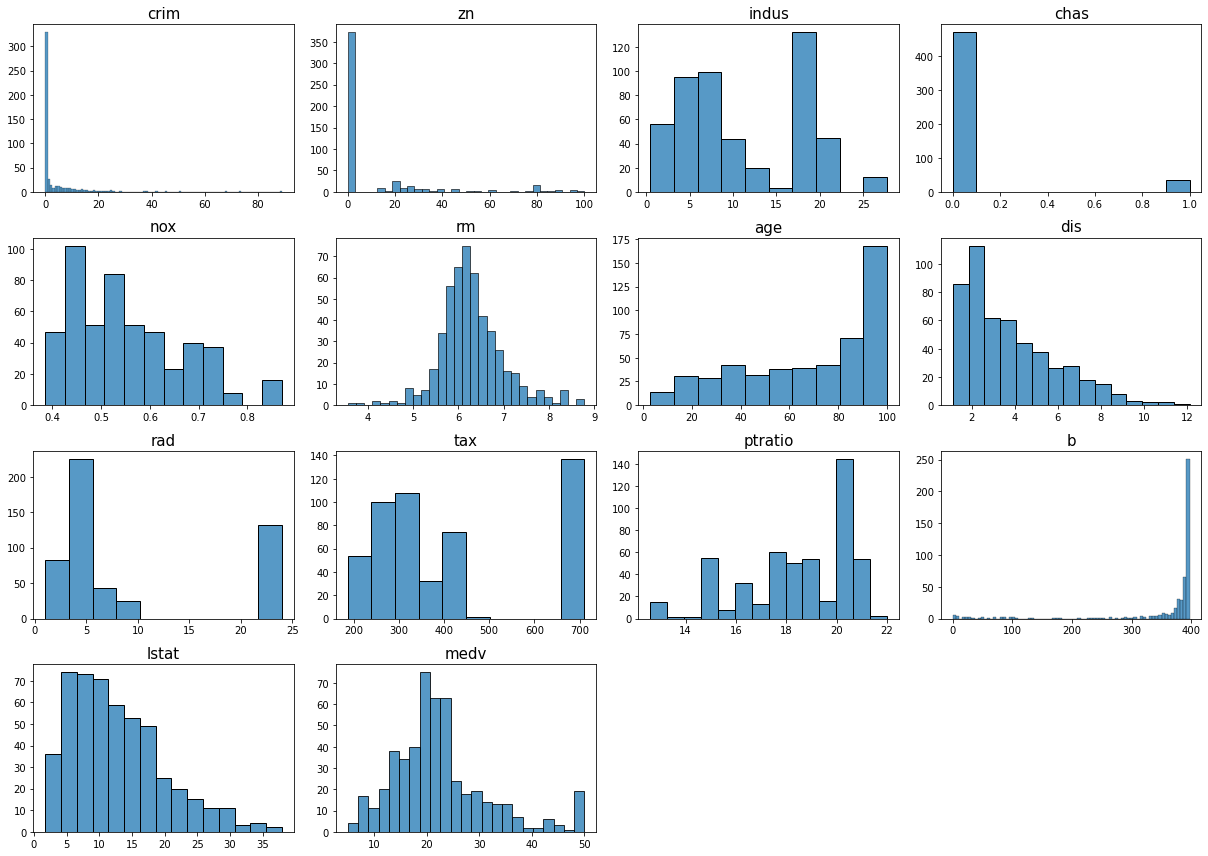

In [14]:
f, axs = plt.subplots(4,4, figsize=(17,12))
row = 0
col_n = 0
for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axs[i//4, i%4])
    axs[i//4, i%4].set_title(col, fontsize=15)
    axs[i//4, i%4].set_xlabel('')
    axs[i//4, i%4].set_ylabel('')
f.delaxes(axs[3,2])
f.delaxes(axs[3,3])
plt.tight_layout()

### Unique

In [15]:
df.nunique()

crim       504
zn          26
indus       76
chas         2
nox         81
rm         446
age        356
dis        412
rad          9
tax         66
ptratio     46
b          357
lstat      455
medv       229
dtype: int64

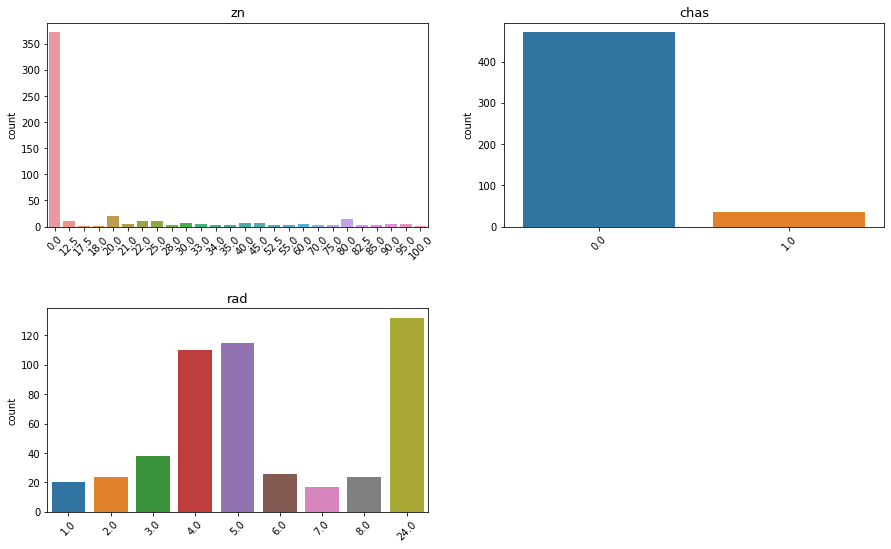

In [16]:
cols = ['zn','chas','rad']

fig, ax = plt.subplots(figsize=(15,9))
plt.subplots_adjust(hspace=0.4)
for i,col in enumerate(cols):
    plt.subplot(2,2,i+1)
    sns.countplot(x=col, data=df)
    plt.title(col, fontsize=13)
    plt.xlabel('')
    plt.xticks(rotation=45)

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## 4) Pairwise Comparisons
Make some pairwise scatterplots of the predictors (columns) in this data set. Describe your findings.

#### Scatterplot Matrix

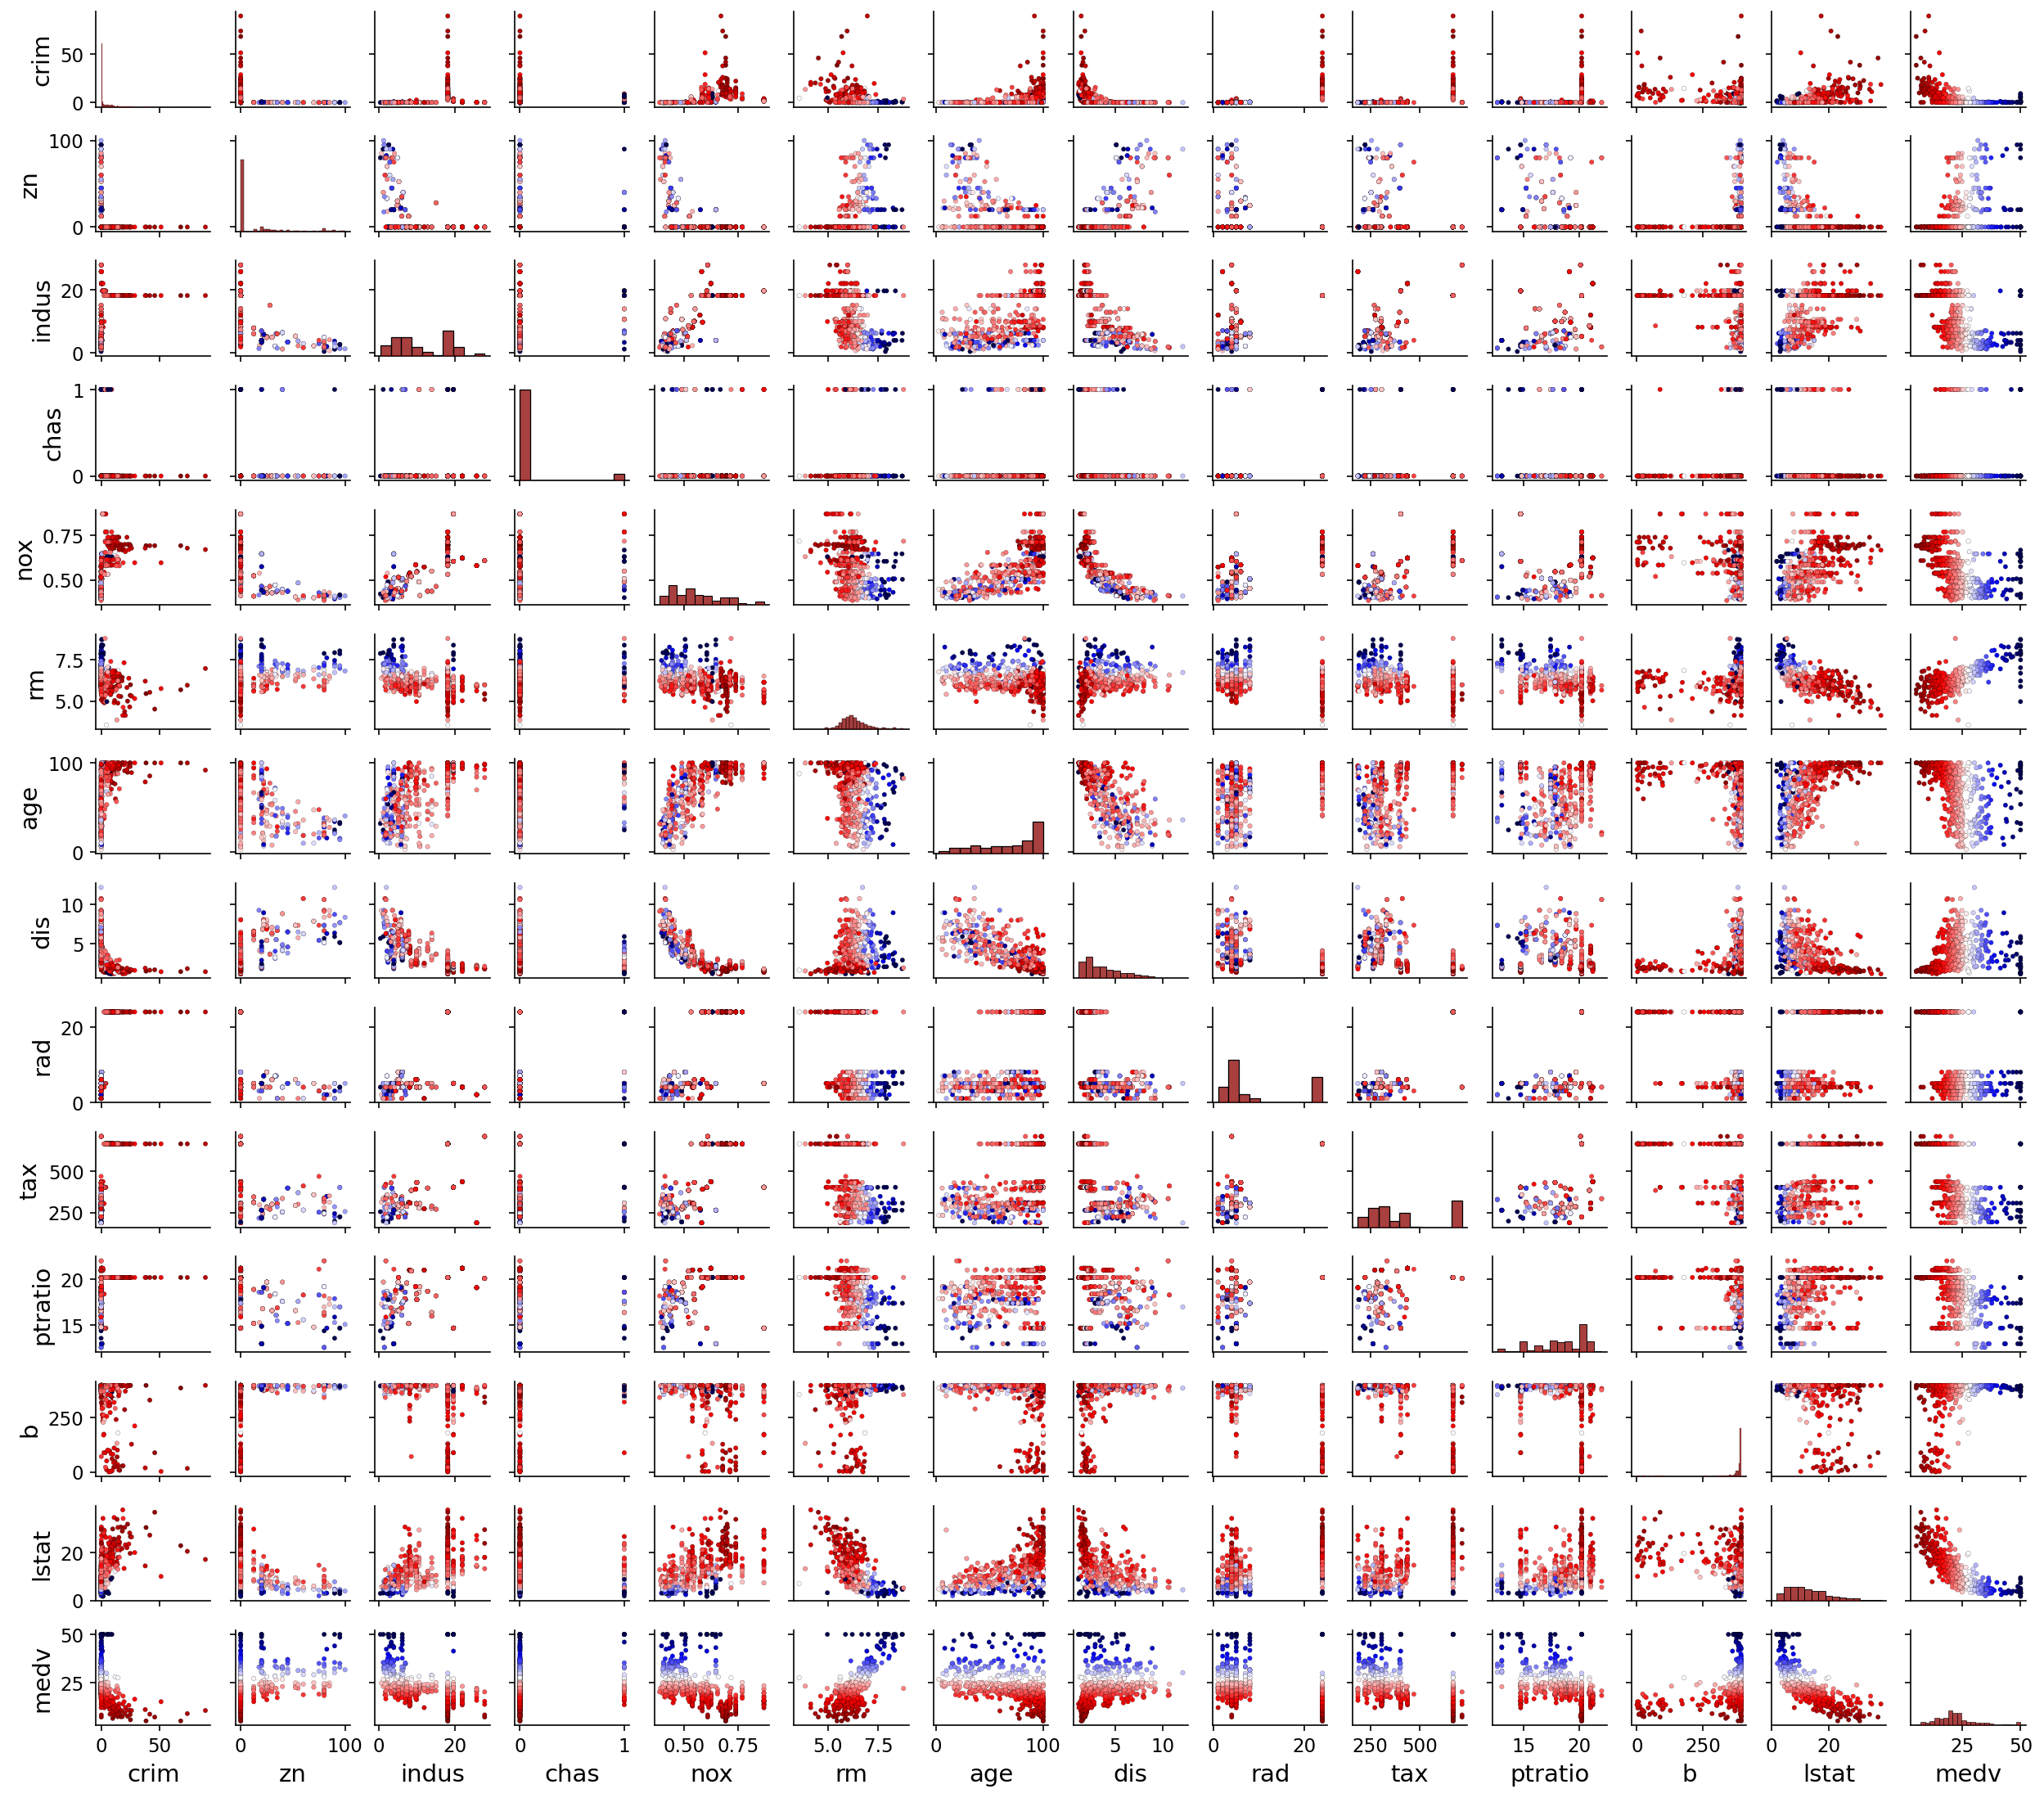

In [17]:
with plt.rc_context():
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 11
    plt.rcParams['ytick.labelsize'] = 11
    
    pp = sns.PairGrid(data=df, height=1)
    plt.gcf().set_size_inches(17,15)
    pp.map_offdiag(sns.scatterplot, hue=df['medv'], palette='seismic_r', s=7, alpha=1,
                        edgecolor='black', linewidth=0.1)
    pp.map_diag(sns.histplot, color='darkred')
    plt.show()

#### Corrleation Matrix

In [18]:
# Correlations >= | 0.55 |
corr = df.corr()
corr.round(3).applymap(lambda x: '-' if abs(x) < 0.55 else x)

crim     zn  indus chas    nox     rm    age    dis    rad    tax  \
crim         1      -      -    -      -      -      -      -  0.626  0.583   
zn           -      1      -    -      -      -  -0.57  0.664      -      -   
indus        -      -      1    -  0.764      -  0.645 -0.708  0.595  0.721   
chas         -      -      -    1      -      -      -      -      -      -   
nox          -      -  0.764    -      1      -  0.731 -0.769  0.611  0.668   
rm           -      -      -    -      -      1      -      -      -      -   
age          -  -0.57  0.645    -  0.731      -      1 -0.748      -      -   
dis          -  0.664 -0.708    - -0.769      - -0.748      1      -      -   
rad      0.626      -  0.595    -  0.611      -      -      -      1   0.91   
tax      0.583      -  0.721    -  0.668      -      -      -   0.91      1   
ptratio      -      -      -    -      -      -      -      -      -      -   
b            -      -      -    -      -      -      -      -      -      -   
lstat        -      -  0.604    -  0.591 -0.614  0.602      -      -      -   
medv         -      -      -    -      -  0.695      -      -      -      -   

        ptratio  b  lstat   medv  
crim          -  -      -      -  
zn            -  -      -      -  
indus         -  -  0.604      -  
chas          -  -      -      -  
nox           -  -  0.591      -  
rm            -  - -0.614  0.695  
age           -  -  0.602      -  
dis           -  -      -      -  
rad           -  -      -      -  
tax           -  -      -      -  
ptratio       1  -      -      -  
b             -  1      -      -  
lstat         -  -      1 -0.738  
medv          -  - -0.738      1

#### Correlation heatmap

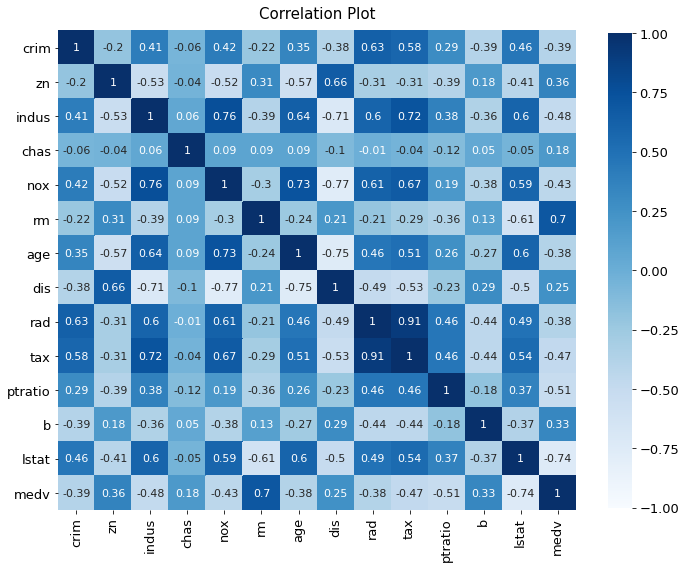

In [19]:
with sns.plotting_context(rc={"xtick.labelsize":13, 'ytick.labelsize':13}):
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr.round(2), vmax=1, vmin=-1, square=False, annot=True, cmap='Blues', center=0,
                annot_kws={"size":11, "weight":"regular"}, cbar_kws={"shrink":.99})
    ax.set_title('Correlation Plot', fontsize=15, weight='regular', pad=12)
    f.tight_layout();

[go to toc](#index)

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## 5) Regression

## a) SLR with each Predictor

### Models

In [20]:
xvars = [x for x in df.columns if x not in ['medv']]

# A dataframe to store critical results
medv_slr_res = pd.DataFrame(columns=['rsq', 'coef', 'pvalue'], index=xvars)

# A dictionary to store the model results
medv_slr_models = {x:smf.ols(f'medv ~ {x}', data=df).fit() for x in xvars}

# Adding values to result dataframe
for model in medv_slr_models:
    medv_slr_res.loc[model] = [medv_slr_models[model].rsquared,
                               medv_slr_models[model].params[model], 
                               medv_slr_models[model].pvalues[model]]

In [21]:
medv_slr = medv_slr_res.astype('float')
medv_slr#.sort_values(by='rsq', ascending=False)

rsq       coef        pvalue
crim     0.150780  -0.415190  1.173987e-19
zn       0.129921   0.142140  5.713584e-17
indus    0.233990  -0.648490  4.900260e-31
chas     0.030716   6.346157  7.390623e-05
nox      0.182603 -33.916055  7.065042e-24
rm       0.483525   9.102109  2.487229e-74
age      0.142095  -0.123163  1.569982e-18
dis      0.062464   1.091613  1.206612e-08
rad      0.145639  -0.403095  5.465933e-19
tax      0.219526  -0.025568  5.637734e-29
ptratio  0.257847  -2.157175  1.609509e-34
b        0.111196   0.033593  1.318113e-14
lstat    0.544146  -0.950049  5.081103e-88

### Statistically Insignificant Predictors

In [22]:
# p-value > 5%
medv_slr[medv_slr.pvalue > 0.05]

Empty DataFrame
Columns: [rsq, coef, pvalue]
Index: []

<div class="alert alert-block alert-info">
    medv has a statistically significant linear relationship (at $\alpha$ = 5%) with every predictor.
</div>

### Plots

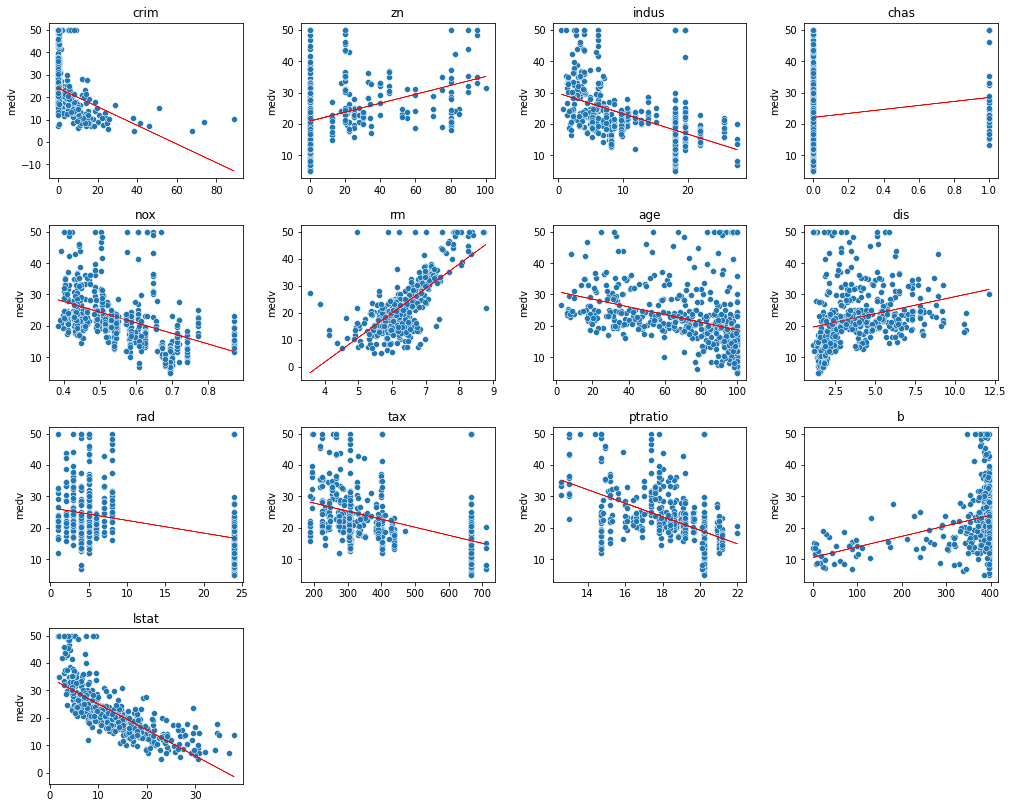

In [23]:
plt.figure(figsize=(17,14))
for i,x in enumerate(xvars):
    plt.subplot(4, 4, i+1)
    sns.scatterplot(x=x, y='medv', data=df)
    plt.plot(df[x], medv_slr_models[x].fittedvalues, lw=0.7, color='r')
    plt.title(x)
    plt.xlabel('')
plt.subplots_adjust(hspace=0.3, wspace=0.3)

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## b) Multiple Linear Regression

In [24]:
formula_str = 'medv ~ ' + ' + '.join(xvars)
formula_str

'medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + b + lstat'

### Model

In [25]:
mreg1 = smf.ols(formula_str, data=df).fit()
mreg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          6.72e-135
Time:                        17:41:08   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.000      26.432      46.487
crim          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
zn             0.0464      0.014      3.382      0.001       0.019       0.073
indus          0.0206      0.061      0.334      0.738      -0.100       0.141
chas           2.6867      0.862      3.118      0.002       0.994       4.380
nox          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
rm             3.8099      0.418      9.116      0.000       2.989       4.631
age            0.0007      0.013      0.052      0.958      -0.025       0.027
dis           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
rad            0.3060      0.066      4.613      0.000       0.176       0.436
tax           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
ptratio       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
b              0.0093      0.003      3.467      0.001       0.004       0.015
lstat         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Statistically Insignificant Predictors

In [26]:
# Statistically insignificant predictors
pd.concat([mreg1.params[mreg1.pvalues > 0.05], mreg1.pvalues[mreg1.pvalues > 0.05]], axis=1,
         keys=['coef','pvalue']).round(4)

coef  pvalue
indus  0.0206  0.7383
age    0.0007  0.9582

We can reject the &ensp; $H_0 : \beta_j = 0$ at $\alpha = 0.05$ &ensp; for the above predictors.

### Statistically Significant Predictors

In [27]:
# Statistically significant predictors
pd.concat([mreg1.params[mreg1.pvalues < 0.05], mreg1.pvalues[mreg1.pvalues < 0.05]], axis=1,
         keys=['coef','pvalue']).round(4)

coef  pvalue
Intercept  36.4595  0.0000
crim       -0.1080  0.0011
zn          0.0464  0.0008
chas        2.6867  0.0019
nox       -17.7666  0.0000
rm          3.8099  0.0000
dis        -1.4756  0.0000
rad         0.3060  0.0000
tax        -0.0123  0.0011
ptratio    -0.9527  0.0000
b           0.0093  0.0006
lstat      -0.5248  0.0000

 <div align="center"><b>-----------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

### Residual Analysis

<b>Model assumptions</b><br>
Validity of a linear model hinges upon certain conditions / assumptions being true. They are:<br>
1. Linearity
2. Homoscedasticity
3. Normality
4. Independence

Diagnostic plots help us detect violations of model assumptions (except Independence, which can be checked by examining the study design).

<br>
<b>Diagnostic Plots</b><br>

<b>1. Residuals v Fitted</b><br>
This plot helps in detecting non-linearity and/or heteroscedasticity. 
If there is a non-linear relationship between a predictor and response that has not been captured by the model, its presence could be revealed here.  
- If the residuals are not roughly centered around 0 (standardized values outside the $\pm$ 2 range are of particular concern) or if there seems to be a pattern to the scatter, that indicates a possible violation of the assumption of linearity.  
- If the spread of the scatter is uneven, that could be an indication of violation of the homoscedasticity assumption.

<b>2. Normal QQ  plot &rarr; standardized residuals</b><br>
This plot checks if residuals are normally distributed. Residuals are standardized before plotting.


<b>3. Scale-Location  &rarr; sqrt(studentized residuals) v Fitted Values</b><br>
Helps in detecting violation of the assumption of homoscedasticity. 
This plot shows if residuals are spread evenly along the range of fitted values.


<b>4. Residuals v Leverage  &rarr; studentized residuals</b><br>
This plot helps in detecting influential cases with the help of Cook's distance. Cook's distance measures the extent of change in model's estimates when an observation is omitted from the data.
Any observation with a CD $\ge$ 1 (highly influential), or a CD substantially larger than others (potentially highly influential), requires investigation.<br>
A more conservative threshold to flag observations for examination in small samples or for larger data sets [source](http://www.mvstats.com/Downloads/Supplements/Advanced_Regression_Diagnostics.pdf)  is :<br> 
$CooksD \ \ge \ \frac{4}{N−k−1}$  


Useful links and Further reading: 
[1](https://stats.stackexchange.com/questions/383468/interpreting-regression-diagnostic-plots), 
[2](https://dept-info.labri.fr/~thebault/STAT/Understanding_Diag_Plots.pdf), 
[3](https://data.library.virginia.edu/diagnostic-plots/), 
[4](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression7.html),
[5](https://online.stat.psu.edu/stat501/lesson/11/11.1), 
[6](https://daviddalpiaz.github.io/appliedstats/model-diagnostics.html), 
[More diagnostics](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression7.html)

<b>Residuals</b>

- Residuals  
$$r_{i} = y_{i} - \hat{y}_{i}$$


- Standardized (or normalized) residuals (aka internally studentized residuals)  
$$r_{i} = \frac{e_{i}} {\sqrt{MSE(1-h_{ii})}}$$  
$h_{ii}$ &rarr; leverage &emsp;
$MSE \Rightarrow$ Mean Squared Error &emsp;
$e_{i} \rightarrow$ error


- Studentized residuals (aka Deleted t residual)  
$$t_i=\frac{d_i}{s(d_i)}=\frac{e_i}{\sqrt{MSE_{(i)}(1-h_{ii})}}$$  
$d_i = y_i-\hat{y}_{(i)}$  
$y_{i}$ &rarr; ith observation  
$\hat{y}_{(i)}$ &rarr; prediction based on a model with the ith observation deleted  
$MSE_{(i)}$ &rarr; MSE based on a model with the ith observation deleted

<br>
<b>Cook' Distance</b><br>
Cook's distance values are calculated using the residual value and leverage.<br>
$$D_i=\dfrac{(y_i-\hat{y}_i)^2}{p \times MSE}\left( \dfrac{h_{ii}}{(1-h_{ii})^2}\right)$$
$p$ &rarr; Number of predictors + 1 (intercept)

<b>Outliers:</b><br>
    A data point that breaks away from the general trend of the data to an abnormal degree.<br>
    One of the rules for identifying potential outliers is observations with Externally Studentized Residual > 3.

<b>High Leverage point:</b><br>
    an extreme x value, or unusual combination of predictor values

<b>Influential observation:</b><br> 
    an observation that unduly influences any part of the regression analysis such as predicted responses, estimated slope coefficients or the hypothesis test results.

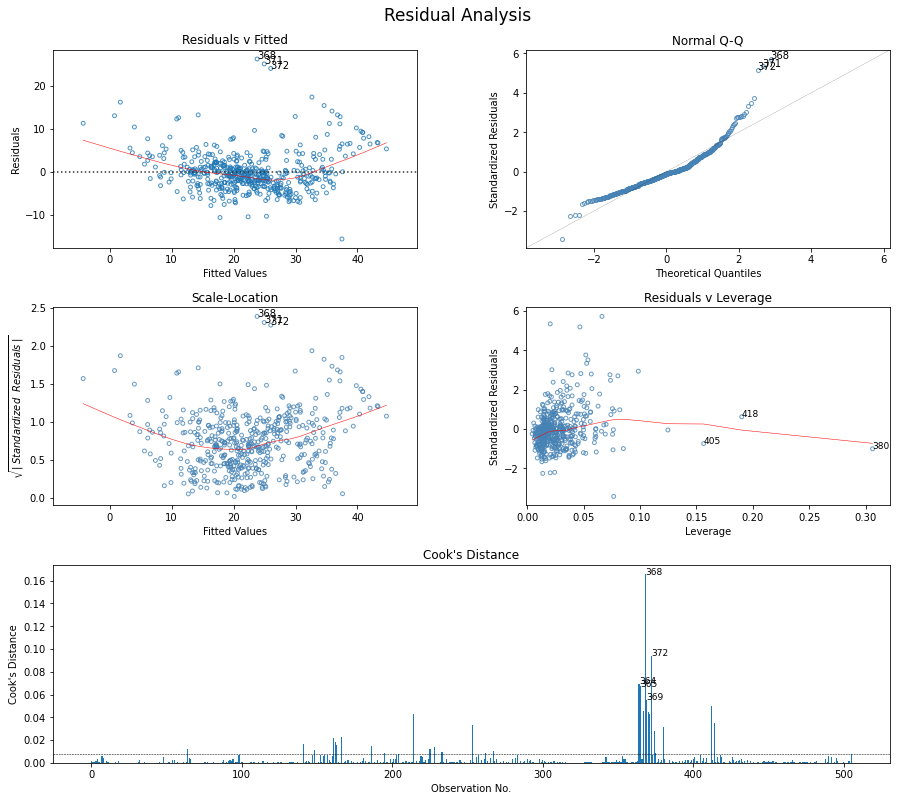

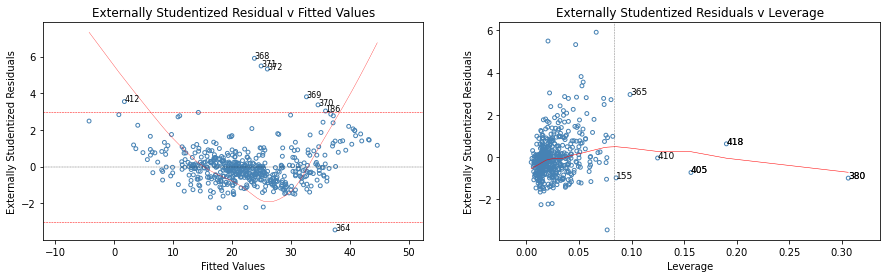

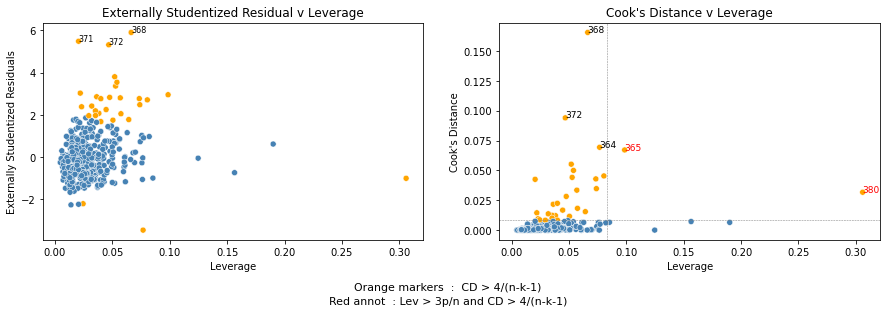

In [28]:
lm_diagnostic_plots(mreg1, df, 'medv')
esr_plots(mreg1)
influence_diagnostic_plots(mreg1)

<a id='obs-mreg1'></a>

<div class="alert alert-block alert-info">
<h5>Observations</h5><br>
    <b>Residuals vs Fitted plot</b><br>
    - There is a clear curved pattern in the scatter. This indicates that the relation between medv and predictors in the model is not linear. Our model is not appropriate.<br>
    <b>Normal QQ plot</b><br>
    - Standardized residuals curve away from the qq-line quite strongly, suggesting a positive skew in the residuals.<br><br>
    Further analysis of the residuals will only make sense when we have a more viable model.
</div>

##### Residuals vs Predictors
Can help us identify possible polynomial relations.

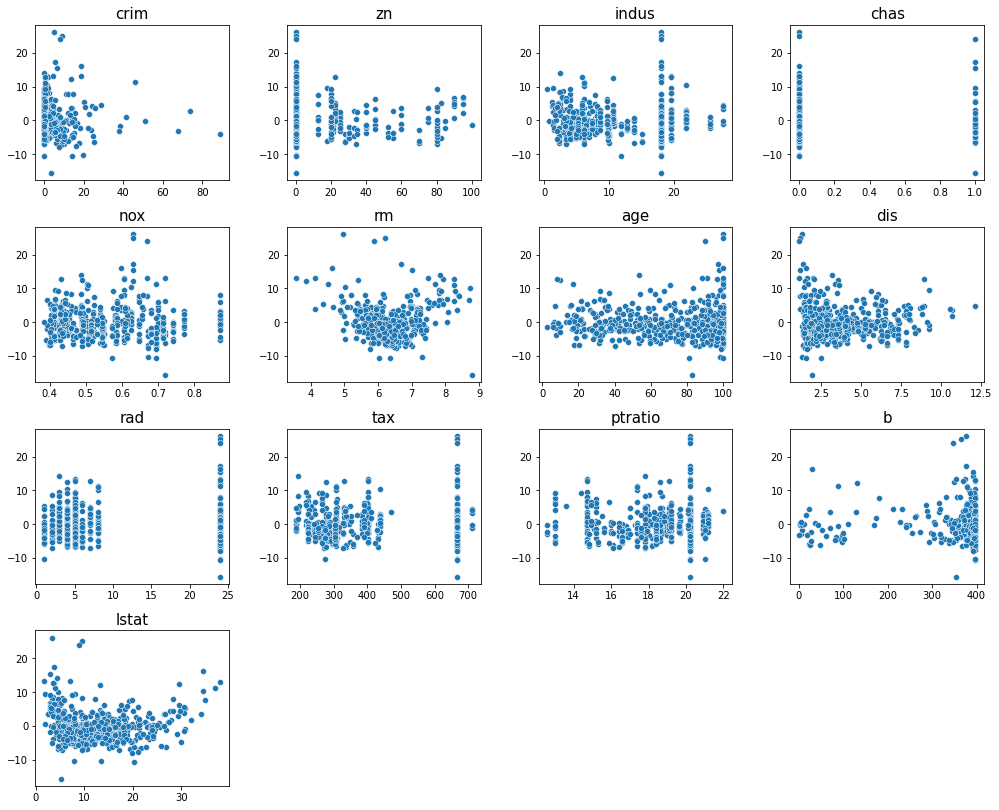

In [29]:
# Residuals vs Predictors
multiplot(X, mreg1.resid, 4)

<div class="alert alert-block alert-info">
    There are slight curved patterns in lstat and rm. We can explore quadratic or cubic transformations for these variables.<br>
    dis makes a funnel pattern with the residuals of the multiple regression model.
</div>

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## c) Multicollinearity 
<br>
<font size=4><b>VIF</b></font>

In [30]:
## Function to calculate VIF and tolerance
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def sm_vif(X_data):
    vif_dict, tolerance_dict = {}, {}
    for i in range(len(X_data.columns)):
        exog = X_data.columns[i]
        vif_dict[exog] = variance_inflation_factor(sm.add_constant(X_data).values, i+1)
        tolerance_dict[exog] = 1 / vif_dict[exog]
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})
    return df_vif

In [31]:
sm_vif(df.drop('medv', axis=1)).round(4).T

crim      zn   indus    chas     nox      rm     age     dis  \
VIF        1.7922  2.2988  3.9916  1.0740  4.3937  1.9337  3.1008  3.9559   
Tolerance  0.5580  0.4350  0.2505  0.9311  0.2276  0.5171  0.3225  0.2528   

              rad     tax  ptratio       b   lstat  
VIF        7.4845  9.0086   1.7991  1.3485  2.9415  
Tolerance  0.1336  0.1110   0.5558  0.7416  0.3400

<div class="alert alert-block alert-info">
    All of the VIF values are below 10. Two variables (rad and tax) have VIF &gt; 5.<br>
    Since the motive is prediction of median house value, multicollinearity is not much of a concern.
</div>

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## d) Non-linear Association
Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form &ensp; 
$Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$

### Cubic Models

In [32]:
# A dataframe to store critical results
medv_plr_res = pd.DataFrame(columns=['rsq', 'x_coef', 'x2_coef', 'x3_coef', 
                                     'x_pval', 'x2_pval',  'x3_pval'], index=xvars)

# A dictionary to store the model results
medv_plr_models = {x:smf.ols(f'medv ~ {x} + np.square({x}) + np.power({x}, 3)', data=df).fit() 
                   for x in xvars}

# Adding values to result dataframe
for model in medv_plr_models:
    medv_plr_res.loc[model] = [medv_plr_models[model].rsquared,
                               medv_plr_models[model].params[1], medv_plr_models[model].params[2],
                               medv_plr_models[model].params[3], medv_plr_models[model].pvalues[1], 
                               medv_plr_models[model].pvalues[2], medv_plr_models[model].pvalues[3]]

In [33]:
medv_plr = medv_plr_res.astype('float').round(4)
medv_plr['relationship'] = medv_plr.apply(lambda x: 'cubic' if x.loc['x3_pval'] < 0.05 else \
                                 'quad' if x.loc['x2_pval'] < 0.05 else \
                                 'linear' if x.loc['x_pval'] < 0.05 else '-', axis=1)
medv_plr

rsq    x_coef   x2_coef   x3_coef  x_pval  x2_pval  x3_pval  \
crim     0.2177   -1.1364    0.0238   -0.0001  0.0000   0.0005   0.0254   
zn       0.1649    0.6434   -0.0168    0.0001  0.0000   0.0000   0.0001   
indus    0.2768   -2.8070    0.1405   -0.0024  0.0000   0.0008   0.0180   
chas     0.0307    2.1154    2.1154    2.1154  0.0001   0.0001   0.0001   
nox      0.1939  315.0960 -615.8267  350.1860  0.1069   0.0552   0.0410   
rm       0.5612 -109.3906   16.4910   -0.7404  0.0000   0.0000   0.0001   
age      0.1566   -0.1224    0.0024   -0.0000  0.5436   0.5494   0.3097   
dis      0.1050    8.5928   -1.2495    0.0560  0.0000   0.0026   0.0215   
rad      0.1767   -3.7995    0.6163   -0.0201  0.0038   0.0010   0.0005   
tax      0.2261   -0.1635    0.0003   -0.0000  0.1496   0.2920   0.3531   
ptratio  0.2669  -48.6911    2.8400   -0.0569  0.0707   0.0700   0.0590   
b        0.1135   -0.0170    0.0002   -0.0000  0.7819   0.5323   0.6409   
lstat    0.6578   -3.8656    0.1487   -0.0020  0.0000   0.0000   0.0000   

        relationship  
crim           cubic  
zn             cubic  
indus          cubic  
chas           cubic  
nox            cubic  
rm             cubic  
age                -  
dis            cubic  
rad            cubic  
tax                -  
ptratio            -  
b                  -  
lstat          cubic

### Statistically Significant Predictors

In [34]:
# Statistically significant predictors
medv_plr_sig = medv_plr[medv_plr.relationship != '-']
medv_plr_sig

rsq    x_coef   x2_coef   x3_coef  x_pval  x2_pval  x3_pval  \
crim   0.2177   -1.1364    0.0238   -0.0001  0.0000   0.0005   0.0254   
zn     0.1649    0.6434   -0.0168    0.0001  0.0000   0.0000   0.0001   
indus  0.2768   -2.8070    0.1405   -0.0024  0.0000   0.0008   0.0180   
chas   0.0307    2.1154    2.1154    2.1154  0.0001   0.0001   0.0001   
nox    0.1939  315.0960 -615.8267  350.1860  0.1069   0.0552   0.0410   
rm     0.5612 -109.3906   16.4910   -0.7404  0.0000   0.0000   0.0001   
dis    0.1050    8.5928   -1.2495    0.0560  0.0000   0.0026   0.0215   
rad    0.1767   -3.7995    0.6163   -0.0201  0.0038   0.0010   0.0005   
lstat  0.6578   -3.8656    0.1487   -0.0020  0.0000   0.0000   0.0000   

      relationship  
crim         cubic  
zn           cubic  
indus        cubic  
chas         cubic  
nox          cubic  
rm           cubic  
dis          cubic  
rad          cubic  
lstat        cubic

In [35]:
# Significant polynomial terms
polyt_significant = medv_plr_sig.index
polyt_significant

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'lstat'], dtype='object')

### Plots

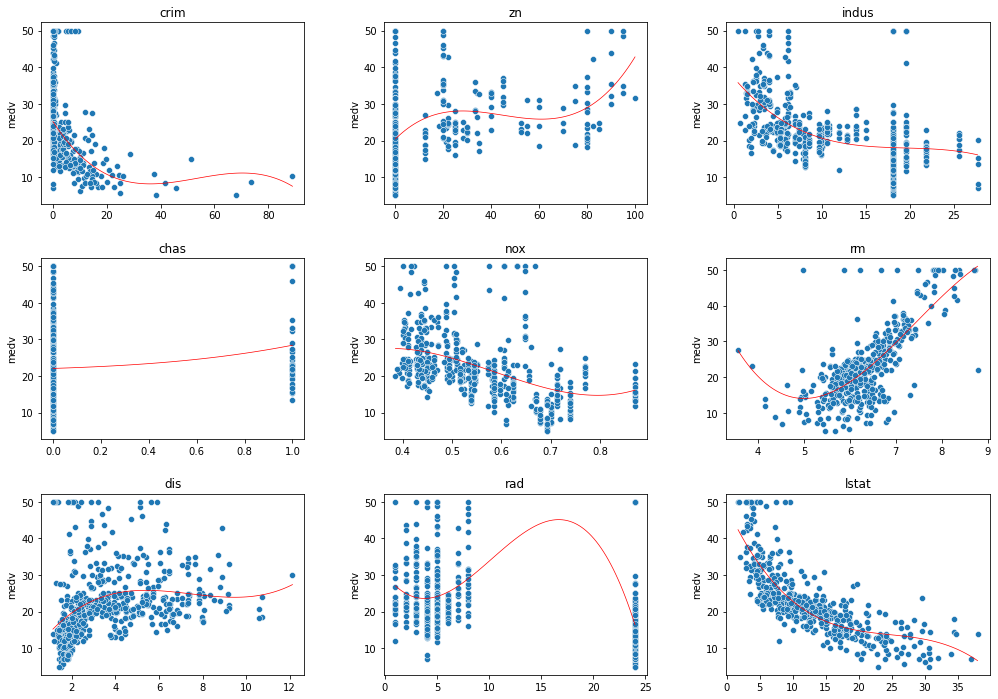

In [36]:
# Response vs Predictor
plt.figure(figsize=(17,12))
for i,x in enumerate(medv_plr_sig.index):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=x, y='medv', data=df)
    if medv_plr_sig.loc[x, 'relationship'] == 'linear':
        plt.plot(df[x], medv_slr_models[x].fittedvalues, lw=0.7, color='r')
    elif medv_plr_sig.loc[x, 'relationship'] == 'cubic':
        xcoord = np.linspace(min(df[x]), max(df[x]), 100)
        ycoord = medv_plr_models[x].params[0] + xcoord*medv_plr_models[x].params[1] + \
        (xcoord**2)*medv_plr_models[x].params[2] + (xcoord**3)*medv_plr_models[x].params[3]
        plt.plot(xcoord, ycoord, lw=0.7, color='r')
    plt.title(x)
    plt.xlabel('')
plt.subplots_adjust(hspace=0.3, wspace=0.3)

<div class="alert alert-block alert-info">
    medv's and nox's relationship with crim seems to have a very nice fit with their respictive cubic regression model lines.<br>
    age and dis also have a good cubic fit with crim.
</div>

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## e) Interaction effects

In [37]:
# Function to return formula string
def regression_formula(yvar, xvars, interaction=False):
    formula_str = f'{yvar} ~ ' + ' + '.join(xvars)
    if interaction:
        interactions = []
        accounted = []
        for i in xvars:
            for j in xvars:
                if (i != j) and (j not in accounted):
                    interactions.append(f"{i}:{j}")
            accounted.append(i)
        intr_form = ' + '.join(interactions)
        formula_str = formula_str + ' + ' + intr_form
    return formula_str

### Model

In [38]:
formula_str = regression_formula('medv', xvars, interaction=True)
formula_str

'medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + b + lstat + crim:zn + crim:indus + crim:chas + crim:nox + crim:rm + crim:age + crim:dis + crim:rad + crim:tax + crim:ptratio + crim:b + crim:lstat + zn:indus + zn:chas + zn:nox + zn:rm + zn:age + zn:dis + zn:rad + zn:tax + zn:ptratio + zn:b + zn:lstat + indus:chas + indus:nox + indus:rm + indus:age + indus:dis + indus:rad + indus:tax + indus:ptratio + indus:b + indus:lstat + chas:nox + chas:rm + chas:age + chas:dis + chas:rad + chas:tax + chas:ptratio + chas:b + chas:lstat + nox:rm + nox:age + nox:dis + nox:rad + nox:tax + nox:ptratio + nox:b + nox:lstat + rm:age + rm:dis + rm:rad + rm:tax + rm:ptratio + rm:b + rm:lstat + age:dis + age:rad + age:tax + age:ptratio + age:b + age:lstat + dis:rad + dis:tax + dis:ptratio + dis:b + dis:lstat + rad:tax + rad:ptratio + rad:b + rad:lstat + tax:ptratio + tax:b + tax:lstat + ptratio:b + ptratio:lstat + b:lstat'

In [39]:
# Regression model with interactions between all variables
imres1 = smf.ols(formula_str, data=df).fit()
imres1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     53.18
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          6.49e-181
Time:                        17:41:16   Log-Likelihood:                -1197.4
No. Observations:                 506   AIC:                             2579.
Df Residuals:                     414   BIC:                             2968.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -157.9354     67.999     -2.323      0.021    -291.601     -24.270
crim            -17.0704      6.554     -2.605      0.010     -29.953      -4.188
zn               -0.0753      0.458     -0.164      0.870      -0.976       0.825
indus            -2.8193      1.696     -1.663      0.097      -6.152       0.514
chas             44.5107     19.523      2.280      0.023       6.134      82.888
nox              20.0562     75.159      0.267      0.790    -127.685     167.797
rm               25.2737      5.699      4.435      0.000      14.071      36.476
age               1.2630      0.273      4.630      0.000       0.727       1.799
dis              -1.6982      4.604     -0.369      0.712     -10.748       7.351
rad               1.8608      2.464      0.755      0.451      -2.982       6.704
tax               0.0367      0.144      0.255      0.799      -0.246       0.320
ptratio           2.7248      2.850      0.956      0.340      -2.877       8.327
b                 0.0994      0.075      1.331      0.184      -0.047       0.246
lstat             1.6556      0.853      1.940      0.053      -0.022       3.333
crim:zn           0.4144      0.180      2.297      0.022       0.060       0.769
crim:indus       -0.0469      0.448     -0.105      0.917      -0.927       0.834
crim:chas         2.4276      0.571      4.251      0.000       1.305       3.550
crim:nox         -1.1080      0.928     -1.193      0.233      -2.933       0.717
crim:rm           0.2163      0.049      4.409      0.000       0.120       0.313
crim:age         -0.0031      0.004     -0.815      0.415      -0.011       0.004
crim:dis         -0.1903      0.106     -1.795      0.073      -0.399       0.018
crim:rad         -0.6584      0.582     -1.132      0.258      -1.801       0.485
crim:tax          0.0348      0.043      0.812      0.417      -0.049       0.119
crim:ptratio      0.4915      0.333      1.477      0.140      -0.163       1.146
crim:b           -0.0005      0.000     -2.572      0.010      -0.001      -0.000
crim:lstat        0.0296      0.007      4.530      0.000       0.017       0.043
zn:indus         -0.0007      0.005     -0.145      0.885      -0.010       0.008
zn:chas          -0.0523      0.064     -0.811      0.418      -0.179       0.074
zn:nox            0.0020      0.472      0.004      0.997      -0.926       0.930
zn:rm            -0.0007      0.026     -0.028      0.978      -0.052       0.050
zn:age        -1.249e-06      0.001     -0.001      0.999      -0.002       0.002
zn:dis            0.0110      0.008      1.452      0.147      -0.004       0.026
zn:rad           -0.0032      0.007     -0.459      0.647      -0.017       0.011
zn:tax            0.0004      0.000      2.209      0.028    4.33e-05       0.001
zn:ptratio       -0.0046      0.007     -0.653   

### Statistically significant predictors

In [40]:
# Statistically significant predictors
medv_intm_sig =  pd.concat([imres1.params[imres1.pvalues < 0.05], imres1.pvalues[imres1.pvalues < 0.05]], axis=1,
                            keys=['coef','pvalue'])
medv_intm_sig

coef        pvalue
Intercept   -157.935363  2.068339e-02
crim         -17.070410  9.525592e-03
chas          44.510740  2.312262e-02
rm            25.273720  1.182238e-05
age            1.262987  4.899235e-06
crim:zn        0.414360  2.212816e-02
crim:chas      2.427601  2.627960e-05
crim:rm        0.216314  1.327176e-05
crim:b        -0.000461  1.045149e-02
crim:lstat     0.029644  7.718377e-06
zn:tax         0.000394  2.774404e-02
zn:lstat      -0.010636  2.303986e-02
indus:nox      3.138448  3.085483e-02
indus:rm       0.330064  1.325690e-02
chas:nox     -32.720067  8.819523e-03
chas:rm       -5.384007  3.868889e-06
nox:age       -0.727286  2.011668e-03
rm:age        -0.062766  4.605608e-03
rm:tax        -0.022417  2.421629e-02
rm:ptratio    -0.488050  2.518930e-02
rm:lstat      -0.296844  2.244600e-11
age:rad        0.014417  6.815875e-04
age:b         -0.000703  1.083413e-03
age:lstat     -0.006023  1.991342e-03
dis:lstat      0.135020  5.773694e-03
tax:ptratio    0.007854  1.829716e-03

In [41]:
# Significant intraction terms
sig_interactions = list(medv_intm_sig.index[~ medv_intm_sig.index.isin(df.columns)][1:])
sig_interactions

['crim:zn',
 'crim:chas',
 'crim:rm',
 'crim:b',
 'crim:lstat',
 'zn:tax',
 'zn:lstat',
 'indus:nox',
 'indus:rm',
 'chas:nox',
 'chas:rm',
 'nox:age',
 'rm:age',
 'rm:tax',
 'rm:ptratio',
 'rm:lstat',
 'age:rad',
 'age:b',
 'age:lstat',
 'dis:lstat',
 'tax:ptratio']

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## f) Experimental Model
This is an experimental model that has been bloated with all the significant predictors, interaction terms, and polynomial terms, for observational purposes.

In [42]:
formula_str = 'medv ~ ' + ' + '.join(xvars)

# Interactions
formula_str = formula_str + ' + ' + ' + '.join(sig_interactions)

# Polynomial
poly_terms = []
for xvar in polyt_significant:
    poly_terms.append(f'np.square({xvar}) + np.power({xvar}, 3)')

formula_str = formula_str + ' + ' + ' + '.join(poly_terms)
formula_str

'medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + b + lstat + crim:zn + crim:chas + crim:rm + crim:b + crim:lstat + zn:tax + zn:lstat + indus:nox + indus:rm + chas:nox + chas:rm + nox:age + rm:age + rm:tax + rm:ptratio + rm:lstat + age:rad + age:b + age:lstat + dis:lstat + tax:ptratio + np.square(crim) + np.power(crim, 3) + np.square(zn) + np.power(zn, 3) + np.square(indus) + np.power(indus, 3) + np.square(chas) + np.power(chas, 3) + np.square(nox) + np.power(nox, 3) + np.square(rm) + np.power(rm, 3) + np.square(dis) + np.power(dis, 3) + np.square(rad) + np.power(rad, 3) + np.square(lstat) + np.power(lstat, 3)'

In [43]:
model1 = smf.ols(formula_str, data=df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     86.73
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          4.77e-201
Time:                        17:41:16   Log-Likelihood:                -1244.6
No. Observations:                 506   AIC:                             2591.
Df Residuals:                     455   BIC:                             2807.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -200.4942     44.992     -4.456      0.000    -288.912    -112.076
crim                  -0.9519      0.558     -1.705      0.089      -2.049       0.145
zn                    -0.0506      0.064     -0.786      0.432      -0.177       0.076
indus                 -2.6636      0.665     -4.003      0.000      -3.971      -1.356
chas                  14.1481      2.233      6.336      0.000       9.760      18.536
nox                  655.8662    149.158      4.397      0.000     362.742     948.991
rm                    18.7489     14.881      1.260      0.208     -10.495      47.993
age                    0.7415      0.138      5.392      0.000       0.471       1.012
dis                   -9.1884      1.379     -6.664      0.000     -11.898      -6.479
rad                    1.6981      0.570      2.980      0.003       0.578       2.818
tax                    0.0195      0.035      0.554      0.580      -0.050       0.089
ptratio                2.6333      1.004      2.622      0.009       0.659       4.607
b                      0.0597      0.014      4.304      0.000       0.032       0.087
lstat                 -0.4522      0.505     -0.895      0.371      -1.445       0.541
crim:zn                0.1370      0.140      0.982      0.327      -0.137       0.411
crim:chas              2.2745      0.300      7.578      0.000       1.685       2.864
crim:rm                0.0739      0.069      1.067      0.286      -0.062       0.210
crim:b                -0.0001      0.000     -0.802      0.423      -0.000       0.000
crim:lstat             0.0013      0.004      0.285      0.776      -0.007       0.010
zn:tax                 0.0002      0.000      1.486      0.138   -5.57e-05       0.000
zn:lstat              -0.0057      0.003     -1.851      0.065      -0.012       0.000
indus:nox              1.0867      0.947      1.147      0.252      -0.775       2.948
indus:rm               0.1805      0.081      2.236      0.026       0.022       0.339
chas:nox             -37.1324      5.572     -6.664      0.000     -48.082     -26.182
chas:rm               -3.5390      0.775     -4.569      0.000      -5.061      -2.017
nox:age               -0.0903      0.167     -0.540      0.590      -0.419       0.239
rm:age                -0.0731      0.014     -5.051      0.000      -0.102      -0.045
rm:tax                -0.0109      0.003     -3.303      0.001      -0.017      -0.004
rm:ptratio            -0.5865      0.129     -4.540      0.000      -0.840      -0.333
rm:lstat              -0.1258      0.063     -2.002      0.046      -0.249      -0.002
age:rad                0.0034      0.002      2.102      0.036       0.000       0.007
age:b                 -0.0006      0.000     -3.761      0.000      -0.001      -0.000
age:lstat             -0.0087      0.0

### Statistically significant predictors

In [44]:
# Statistically significant predictors
pd.concat([model1.params[model1.pvalues < 0.05], model1.pvalues[model1.pvalues < 0.05]], axis=1,
           keys=['coef','pvalue'])

coef        pvalue
Intercept           -200.494202  1.051602e-05
indus                 -2.663597  7.306088e-05
chas                  14.148134  5.668908e-10
nox                  655.866169  1.367170e-05
age                    0.741482  1.120674e-07
dis                   -9.188372  7.709069e-11
rad                    1.698129  3.038651e-03
ptratio                2.633316  9.040195e-03
b                      0.059684  2.055884e-05
crim:chas              2.274473  1.989008e-13
indus:rm               0.180463  2.581278e-02
chas:nox             -37.132378  7.717453e-11
chas:rm               -3.538986  6.319837e-06
rm:age                -0.073094  6.385185e-07
rm:tax                -0.010897  1.031101e-03
rm:ptratio            -0.586481  7.224399e-06
rm:lstat              -0.125770  4.585247e-02
age:rad                0.003426  3.611663e-02
age:b                 -0.000600  1.916606e-04
age:lstat             -0.008653  3.244058e-07
dis:lstat              0.150383  4.402837e-10
np.square(indus)       0.088068  2.717904e-03
np.power(indus, 3)    -0.001971  3.517129e-03
np.square(chas)       14.148134  5.668910e-10
np.power(chas, 3)     14.148134  5.668910e-10
np.square(nox)     -1112.914773  9.005551e-06
np.power(nox, 3)     590.206872  4.199423e-06
np.square(dis)         1.007498  7.488544e-06
np.power(dis, 3)      -0.040481  5.986058e-04
np.square(rad)        -0.203555  1.119463e-02
np.power(rad, 3)       0.005905  1.802612e-02
np.square(lstat)       0.043601  5.743490e-03

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

## g) Feature Selection
The purpose of feature selection is :<br>
a) to make sure that our model is built upon an information base of all the predictors that are relevant and significant for our response variable,<br>
b) while keeping the model as simple as possible.

### 1) Best Subsets Selections
The general idea behind best subsets regression is that we select the subset of predictors that do the best at meeting some well-defined objective criterion, such as having the largest $R^{2}$ value or the smallest MSE.
Different criteria quantify different aspects of the regression model, and therefore often yield different choices for the best set of predictors.
We have to pick the criteria that best suits our needs.

Generally, there is no one best model. 
There can be multiple models that perform equally well or marginally well than others or perform better than other models on some criterion and worse in others. 
Best subsets selection method is used as a screening tool to pare down the number of candidate models, which can then be evaluated further (residual analysis etc) before arriving at one final model.

Best subsets regression procedure involves the following steps:<br>
1) Create models from all possible combinations of candidate predictors<br>
&emsp; No. of combinations = $2^n - 1$.<br>
&emsp; For this dataset with 13 predictors, there are $2^{13}$ = 8192 combinations including 1 combination with 0 predictors.<br>

2) Shortlist those combinations that do the best at meeting some well-defined criteria.<br>
For example: model with <br>
    - lowest MSE, or<br>
    - largest Adjusted $R^2$ value<br>
    - Cp statistic close to p<br>

3) Further evaluate and refine the shortlisted models to arrive at a final model that satisfactorily summarizes the trend in the data and more importantly, meets the goal of the project.<br>
This step entails, residual analysis, data transformations, adding interaction terms if required.

<br><b>Bias</b><br>
Bias is introduced in the model because of our presumption as to the nature of relationship ($f(x)$) between the response variable and predictors.<br>
Here, we are presuming that the relationship between medv and other variables can be modeled with linear regression.
The true relationship would almost always differ from any model that we come up with.
This difference will contribute to the variance between true y values and predicted y values and is known as <i>Bias</i>.
If our model is closer to the true relationship, the contribution of this <i>bias</i> to the residual sum of squares will be less.


#### Mallow's Cp
A model from which important predictors are missing is called an underspecified model.
And, an underspecified model yields biased regression coefficients and biased predictions of the response. 

A (standardized) measure of the total variation in the predicted responses is denoted by $\Gamma_p$ and is made up of 2 components.<br>

$$\Gamma_p = \dfrac{1}{\sigma^2} \left\{ \sum_{i=1}^{n}\sigma_{\hat{y}_i}^{2} + \sum_{i=1}^{n} (E(\hat{y}_i) - E(y_i))^2 \right\}$$

$\sum_{i=1}^{n}\sigma_{\hat{y}_i}^{2}$  &rArr; quantifies the random sampling variation.<br>
$\sum_{i=1}^{n} (E(\hat{y}_i) - E(y_i))^2 $ &rArr; quantifies the bias.<br>
$\dfrac{1}{\sigma^2}$ &rArr; to get a standardized unitless measure<br>

<br>
$\Gamma_p$ is a good measure of an underspecified model.
Theroetical minimum value for $\Gamma_p$ = p
The best model is the one with $\Gamma_p$ closest to p.

<b>Mallows' $C_p$ statistic is an estimate of $\Gamma_p$.</b>
It estimates the size of the bias that is introduced into the predicted responses by having an underspecified model.<br>

<i>Formula: </i>
$$ C_p = \dfrac{SSE_p}{MSE_{all}}-(n-2p) $$

$p$ &rarr; intercept + no. of predictors in the subset<br>
$\sigma^2$ is estimated with $MSE_{all}$, the MSE for the model containing all the predictors (full model), and is based on the assumption that there are not biases in the full model.


Models with low $C_p$ values have a small total (standardized) variance of prediction.<br>
When the $C_p$ value is:<br>
    &nbsp; • near p &nbsp; &rarr; &nbsp; the bias is small (next to none)<br>
    &nbsp; • much greater than p &nbsp; &rarr; &nbsp; the bias is substantial<br>
    &nbsp; • below p &nbsp; &rarr; &nbsp; it is due to sampling error; interpret as no bias<br>
$C_p$ statistic = p  for the model containing all the predictors, therefore it shall not be used to judge the full model.<br>

#### Creating models and calculating important metrics

In [45]:
# Importing tqdm for the progress bar
from tqdm.notebook import tnrange
import itertools

In [46]:
# Function to fit a linear regression model and return metrics
def fit_linear_reg(X,y):
    model_k = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    mse = model_k.mse_resid           # mean squared error
    rss = model_k.ssr                 # residual sum of squares
    rsq = model_k.rsquared            # r-squared
    adj_rsq = model_k.rsquared_adj    # Adjusted r-squared
    return mse, rss, rsq, adj_rsq

In [47]:
# Creating dataframe with important metrics
X = df[df.columns[~df.columns.isin(['medv'])]]
y = df['medv']

mse_list, rss_list, r_squared_list, adj_rsq_list = [], [], [], []
feature_list, numb_features = [], []
k = len(X.columns)
features = []
features_list = dict()

# Loop over all possible subsets of predictors
for k in tnrange(1, len(X.columns)+1, desc = 'Loop   '):
    for combo in itertools.combinations(X.columns, k):
        feature_list.append(combo)
        numb_features.append(len(combo))
        temp_model = fit_linear_reg(X[list(combo)], y)
        mse_list.append(temp_model[0])
        rss_list.append(temp_model[1])
        r_squared_list.append(temp_model[2]*100)
        adj_rsq_list.append(temp_model[3]*100)
        

# Store metrics in DataFrame
res_df = pd.DataFrame({'features':feature_list, 'p': np.add(numb_features,1), 'resid_ss': rss_list, 
                      'mse': mse_list, 'rsq':r_squared_list, 'adj_rsq':adj_rsq_list})

res_df.head(15)

features  p      resid_ss        mse        rsq    adj_rsq
0         (crim,)  2  36275.512356  71.975223  15.078047  14.909551
1           (zn,)  2  37166.558224  73.743171  12.992084  12.819450
2        (indus,)  2  32721.108150  64.922834  23.399003  23.247017
3         (chas,)  2  41404.216144  82.151223   3.071613   2.879295
4          (nox,)  2  34916.169908  69.278115  18.260304  18.098122
5           (rm,)  2  22061.879196  43.773570  48.352546  48.250070
6          (age,)  2  36646.534350  72.711378  14.209474  14.039255
7          (dis,)  2  40048.048843  79.460414   6.246437   6.060418
8          (rad,)  2  36495.154812  72.411021  14.563858  14.394342
9          (tax,)  2  33338.961320  66.148733  21.952592  21.797736
10     (ptratio,)  2  31702.013207  62.900820  25.784732  25.637479
11           (b,)  2  37966.409179  75.330177  11.119612  10.943262
12       (lstat,)  2  19472.381418  38.635677  54.414630  54.324183
13     (crim, zn)  3  32721.176159  65.052040  23.398844  23.094267
14  (crim, indus)  3  30841.811547  61.315729  27.798487  27.511404

In [48]:
# Full model
# res_df.tail(1)
res_df[res_df.p - 1 == len(X.columns)]

features   p      resid_ss  \
8190  (crim, zn, indus, chas, nox, rm, age, dis, rad...  14  11078.784578   

            mse        rsq    adj_rsq  
8190  22.517855  74.064266  73.378973

In [49]:
# Calculate Mallow's Cp
mse_full_model = res_df.iloc[-1]['mse']
res_df['Cp'] = (res_df.resid_ss/mse_full_model) - (len(df) - 2*res_df.p)
res_df['Cp-p'] = res_df['Cp'] - res_df['p']
res_df.head(15)

features  p      resid_ss        mse        rsq    adj_rsq  \
0         (crim,)  2  36275.512356  71.975223  15.078047  14.909551   
1           (zn,)  2  37166.558224  73.743171  12.992084  12.819450   
2        (indus,)  2  32721.108150  64.922834  23.399003  23.247017   
3         (chas,)  2  41404.216144  82.151223   3.071613   2.879295   
4          (nox,)  2  34916.169908  69.278115  18.260304  18.098122   
5           (rm,)  2  22061.879196  43.773570  48.352546  48.250070   
6          (age,)  2  36646.534350  72.711378  14.209474  14.039255   
7          (dis,)  2  40048.048843  79.460414   6.246437   6.060418   
8          (rad,)  2  36495.154812  72.411021  14.563858  14.394342   
9          (tax,)  2  33338.961320  66.148733  21.952592  21.797736   
10     (ptratio,)  2  31702.013207  62.900820  25.784732  25.637479   
11           (b,)  2  37966.409179  75.330177  11.119612  10.943262   
12       (lstat,)  2  19472.381418  38.635677  54.414630  54.324183   
13     (crim, zn)  3  32721.176159  65.052040  23.398844  23.094267   
14  (crim, indus)  3  30841.811547  61.315729  27.798487  27.511404   

             Cp         Cp-p  
0   1108.966614  1106.966614  
1   1148.537251  1146.537251  
2    951.118354   949.118354  
3   1336.728265  1334.728265  
4   1048.599298  1046.599298  
5    477.750485   475.750485  
6   1125.443405  1123.443405  
7   1276.501955  1274.501955  
8   1118.720761  1116.720761  
9    978.556721   976.556721  
10   905.861159   903.861159  
11  1184.057995  1182.057995  
12   362.752951   360.752951  
13   953.121374   950.121374  
14   869.660288   866.660288

#### Subsets with lowest Mallow's Cp

In [50]:
# Subsets with 2 lowest Cp values for each level of p
mallow = res_df.iloc[res_df.groupby('p')['Cp-p'].nsmallest(1).index.get_level_values(1)]
mallow.style.background_gradient(cmap='PuBu_r', vmin=0, vmax=30, subset=['Cp-p'])\
.background_gradient(cmap='coolwarm', vmin=22, vmax=25, subset=['mse'])\
.background_gradient(cmap='coolwarm_r', vmin=70, vmax=max(mallow.adj_rsq), subset=['adj_rsq'])

<div class="alert alert-block alert-info">
    From the above table, we can see that starting with p=7 level, with each increment in p, there is:<br>
    - marginal increase (&lt; 1) in adjusted r-squared<br>
    - marginal decrease in mse (&lt; 0.6).<br>
    - more than marginal decrease in Cp-p<br>
    Model with p=12 has Cp &lt; p.<br>
    Models with p=10,11 have Cp statistic not much larger than p (&lt; 20).<br>
    They can be shortlisted for further evaluation.
</div>

##### --&nbsp; <i>Workings</i> &nbsp; --------------------------------------------------------------

In [51]:
# Subsets with smallest mse for each p level
res_df.iloc[res_df.groupby('p')['mse'].nsmallest(1).index.get_level_values(1)]

features   p      resid_ss  \
12                                             (lstat,)   2  19472.381418   
69                                          (rm, lstat)   3  15439.309201   
340                                (rm, ptratio, lstat)   4  13727.985314   
1045                          (rm, dis, ptratio, lstat)   5  13228.907703   
2276                     (nox, rm, dis, ptratio, lstat)   6  12469.344151   
3908               (chas, nox, rm, dis, ptratio, lstat)   7  12141.072736   
5720            (chas, nox, rm, dis, ptratio, b, lstat)   8  11868.235607   
6842        (zn, chas, nox, rm, dis, ptratio, b, lstat)   9  11678.299470   
7566  (crim, chas, nox, rm, dis, rad, ptratio, b, ls...  10  11526.122446   
7975  (crim, zn, nox, rm, dis, rad, tax, ptratio, b,...  11  11308.577606   
8150  (crim, zn, chas, nox, rm, dis, rad, tax, ptrat...  12  11081.363952   
8183  (crim, zn, indus, chas, nox, rm, dis, rad, tax...  13  11078.846412   
8190  (crim, zn, indus, chas, nox, rm, age, dis, rad...  14  11078.784578   

            mse        rsq    adj_rsq          Cp        Cp-p  
12    38.635677  54.414630  54.324183  362.752951  360.752951  
69    30.694452  63.856161  63.712448  185.647426  182.647426  
340   27.346584  67.862416  67.670359  111.648895  107.648895  
1045  26.405005  69.030770  68.783511   91.485256   86.485256  
2276  24.938688  70.808929  70.517018   59.753643   53.753643  
3908  24.330807  71.577421  71.235667   47.175371   40.175371  
5720  23.831798  72.216140  71.825604   37.058891   29.058891  
6842  23.497584  72.660786  72.220718   30.623979   21.623979  
7566  23.238150  73.017036  72.527426   25.865918   15.865918  
7975  22.845611  73.526315  72.991493   18.204925    7.204925  
8150  22.431911  74.058228  73.480577   10.114548   -1.885452  
8183  22.472305  74.064122  73.432822   12.002746   -0.997254  
8190  22.517855  74.064266  73.378973   14.000000    0.000000

In [52]:
# Subsets with largest adj_rsq for each p level
res_df.iloc[res_df.groupby('p')['adj_rsq'].nlargest(1).index.get_level_values(1)]

features   p      resid_ss  \
12                                             (lstat,)   2  19472.381418   
69                                          (rm, lstat)   3  15439.309201   
340                                (rm, ptratio, lstat)   4  13727.985314   
1045                          (rm, dis, ptratio, lstat)   5  13228.907703   
2276                     (nox, rm, dis, ptratio, lstat)   6  12469.344151   
3908               (chas, nox, rm, dis, ptratio, lstat)   7  12141.072736   
5720            (chas, nox, rm, dis, ptratio, b, lstat)   8  11868.235607   
6842        (zn, chas, nox, rm, dis, ptratio, b, lstat)   9  11678.299470   
7566  (crim, chas, nox, rm, dis, rad, ptratio, b, ls...  10  11526.122446   
7975  (crim, zn, nox, rm, dis, rad, tax, ptratio, b,...  11  11308.577606   
8150  (crim, zn, chas, nox, rm, dis, rad, tax, ptrat...  12  11081.363952   
8183  (crim, zn, indus, chas, nox, rm, dis, rad, tax...  13  11078.846412   
8190  (crim, zn, indus, chas, nox, rm, age, dis, rad...  14  11078.784578   

            mse        rsq    adj_rsq          Cp        Cp-p  
12    38.635677  54.414630  54.324183  362.752951  360.752951  
69    30.694452  63.856161  63.712448  185.647426  182.647426  
340   27.346584  67.862416  67.670359  111.648895  107.648895  
1045  26.405005  69.030770  68.783511   91.485256   86.485256  
2276  24.938688  70.808929  70.517018   59.753643   53.753643  
3908  24.330807  71.577421  71.235667   47.175371   40.175371  
5720  23.831798  72.216140  71.825604   37.058891   29.058891  
6842  23.497584  72.660786  72.220718   30.623979   21.623979  
7566  23.238150  73.017036  72.527426   25.865918   15.865918  
7975  22.845611  73.526315  72.991493   18.204925    7.204925  
8150  22.431911  74.058228  73.480577   10.114548   -1.885452  
8183  22.472305  74.064122  73.432822   12.002746   -0.997254  
8190  22.517855  74.064266  73.378973   14.000000    0.000000

</a><div class="alert alert-block alert-info">
Both criteria (minimum squared residual and maximum r-squared) give the same best combinations.
</div>

<b><i>--------------------------------------------------------------&nbsp; Workings &nbsp;--</i></b>

 <div align="center"><b>-----------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

#### Residual Analysis

In [53]:
# Shorlisted models
display(mallow[(mallow['Cp-p']<20) & (mallow['p']<13)])

mallow_shortlist = {}
for subset in mallow[(mallow['Cp-p']<20) & (mallow['p']<13)]['features']:
    mallow_shortlist[len(subset)+1] = subset
    print(subset)

features   p      resid_ss  \
7566  (crim, chas, nox, rm, dis, rad, ptratio, b, ls...  10  11526.122446   
7975  (crim, zn, nox, rm, dis, rad, tax, ptratio, b,...  11  11308.577606   
8150  (crim, zn, chas, nox, rm, dis, rad, tax, ptrat...  12  11081.363952   

            mse        rsq    adj_rsq         Cp       Cp-p  
7566  23.238150  73.017036  72.527426  25.865918  15.865918  
7975  22.845611  73.526315  72.991493  18.204925   7.204925  
8150  22.431911  74.058228  73.480577  10.114548  -1.885452

('crim', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'b', 'lstat')
('crim', 'zn', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat')
('crim', 'zn', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat')


##### Model 1  : p = 10

'medv ~ crim + chas + nox + rm + dis + rad + ptratio + b + lstat'

rsq = 73.017
adj_rsq = 72.5274
mse = 23.2382


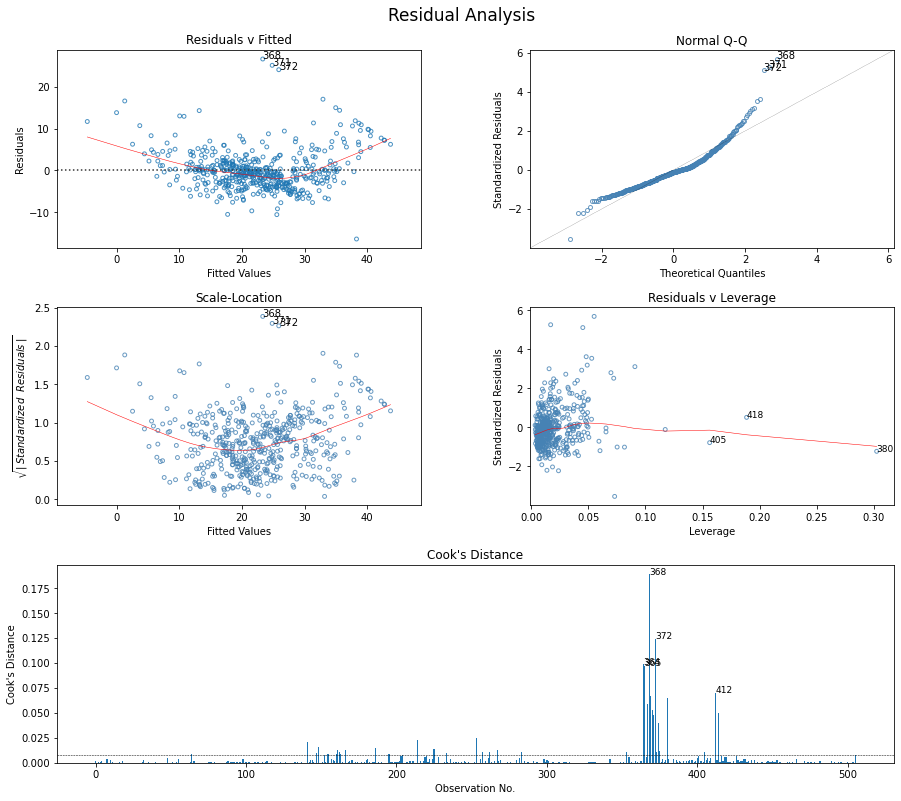

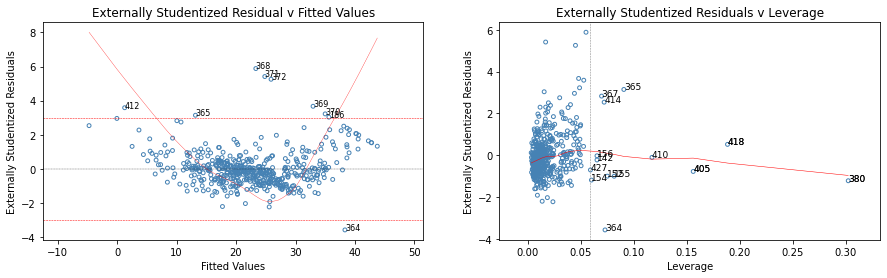

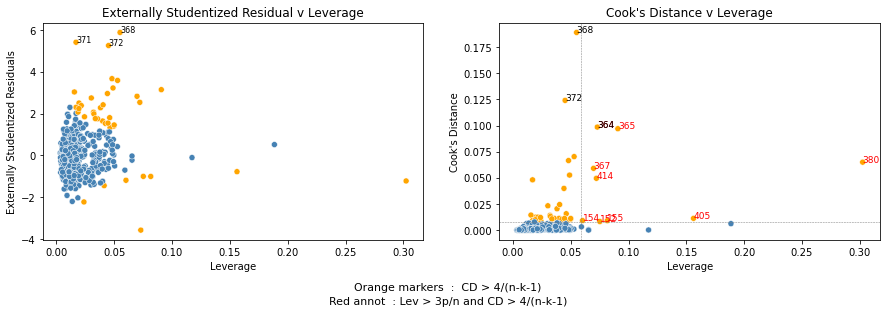

In [54]:
formula_str = regression_formula('medv', mallow_shortlist[10])
display(formula_str)
msh1 = smf.ols(formula_str, data=df).fit()
print(f'rsq = {round(msh1.rsquared*100, 4)}')
print(f'adj_rsq = {round(msh1.rsquared_adj*100, 4)}')
print(f'mse = {round(msh1.scale, 4)}')

# Diagnostic plots
lm_diagnostic_plots(msh1, df, 'medv')
esr_plots(msh1)
influence_diagnostic_plots(msh1)

<div class="alert alert-block alert-info">
    We can observe a curve in the residuals vs fitted plot.<br>
    We had seen above that many variables had a significant cubic association with medv (one on one).<br>
    We need to try out transformations for them.<br>We can start with the variable that exhibited the best fit for cubic association : lstat
</div>

##### Transformations

rsq = 78.2096
adj_rsq = 77.7694
mse = 18.8041


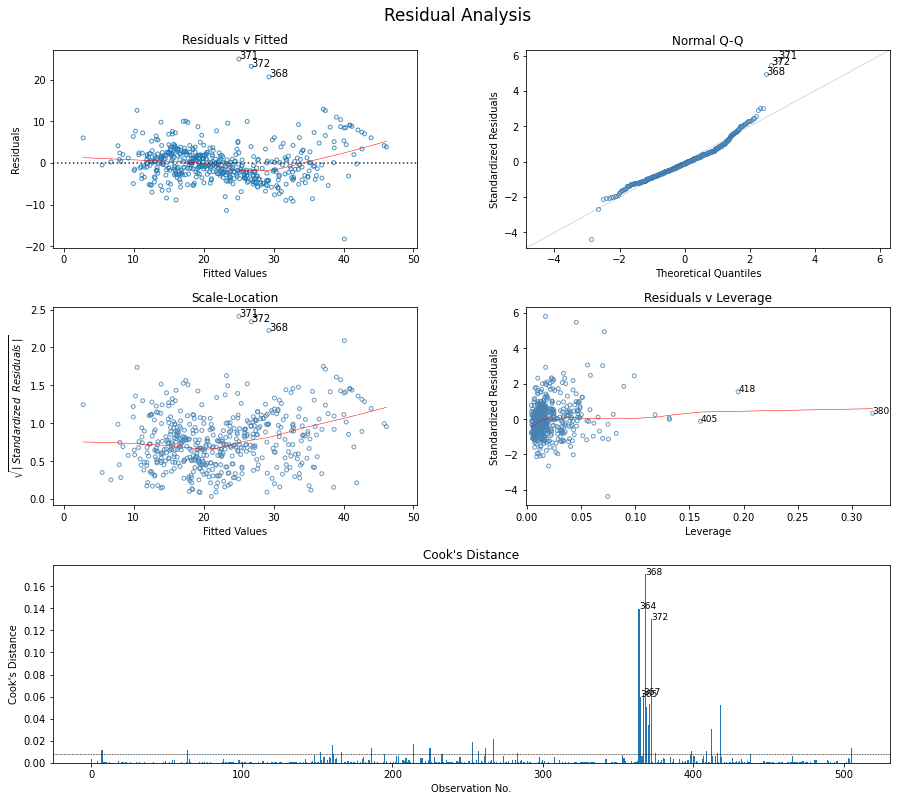

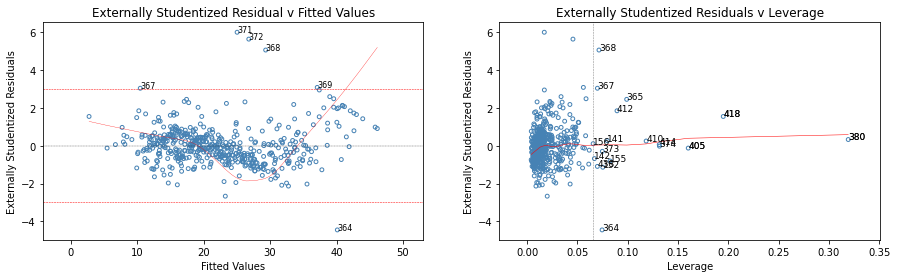

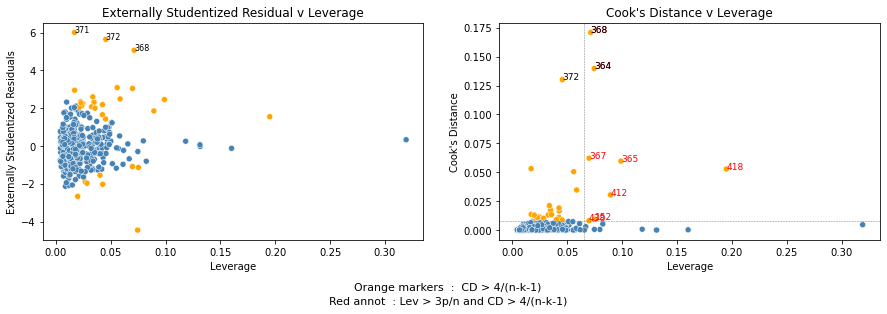

In [55]:
formula_str = 'medv ~ crim + chas + nox + rm + dis + rad + ptratio + b + lstat + np.square(lstat)'

msh1 = smf.ols(formula_str, data=df).fit()
print(f'rsq = {round(msh1.rsquared*100, 4)}')
print(f'adj_rsq = {round(msh1.rsquared_adj*100, 4)}')
print(f'mse = {round(msh1.scale, 4)}')

# Diagnostic plots
lm_diagnostic_plots(msh1, df, 'medv')
esr_plots(msh1)
influence_diagnostic_plots(msh1)

rsq = 78.4375
adj_rsq = 77.9573
mse = 18.6452


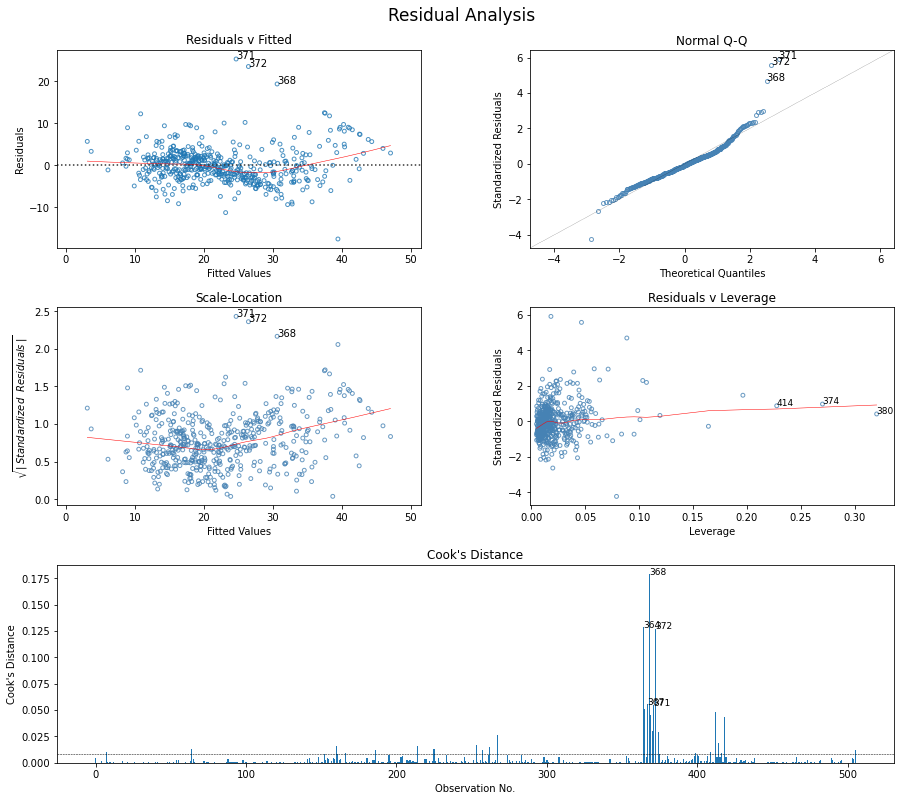

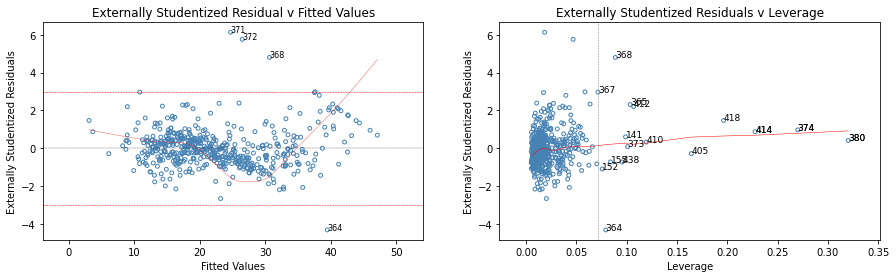

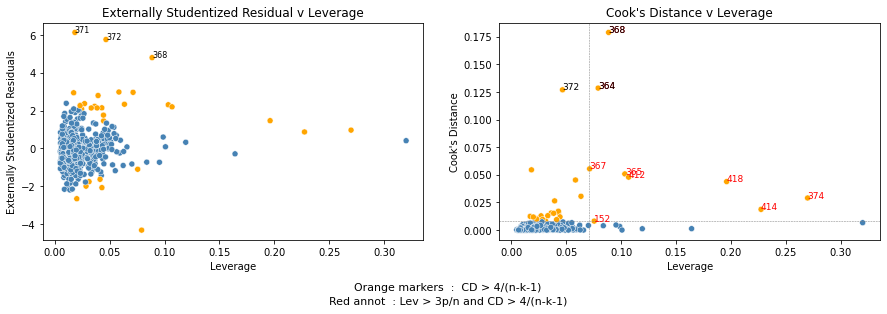

In [56]:
formula_str = 'medv ~ crim + chas + nox + rm + dis + rad + ptratio + b + lstat + np.square(lstat) \
+ np.power(lstat,3)'

msh1 = smf.ols(formula_str, data=df).fit()
print(f'rsq = {round(msh1.rsquared*100, 4)}')
print(f'adj_rsq = {round(msh1.rsquared_adj*100, 4)}')
print(f'mse = {round(msh1.scale, 4)}')

# Diagnostic plots
lm_diagnostic_plots(msh1, df, 'medv')
esr_plots(msh1)
influence_diagnostic_plots(msh1)

<div class="alert alert-block alert-info">
    1) Adding a quadratic term for lstat<br>
        - straightened the curve noticably<br>
        - decreased the mse considerably from 23.238 to 18.804.<br>
        - increased adjusted rsq significantly from 72.53 to 77.77.<br><br>
    2) Adding the cubic term for lstat<br>
        - did not change the curve noticably<br>
        - marginal decrease in mse from 18.804 to 18.645.<br>
        - marginal increase in adjusted rsq from 77.77 to 77.95<br>
    We will stick with the quadratic lstat transformation for now and make transformations in other predictors wherever beneficial.<br><br>
    <b>Observations for various iterations :</b><br>
    1) <b>lstat</b> &rarr; power raised to : 2 &rarr; effect : significant<br>
    2) <b>rm</b> &rarr; power raised to : 2 &rarr; effect : significant<br>
    &ensp; obs-364 became a considerable outlier, its removal could result in significant improvement in metrics<br>
    3) <b>crim</b> &rarr; power raised to : 0 &rarr; effect : marginal-moderate<br>
    4) <b>dis</b> &rarr; power raised to : 0 &rarr; effect : marginal-moderate<br><br>
    <b>response transformation</b><br>
    Underoot transformation (insted of log) of medv <br>
    - decreased mse very significantly (around 14)<br>
    - yielded a flatter lowess line in the scale-location plot.<br>
</div>

##### Final model for p=10

rsq = 82.2192, 		 incr: -0.0
adj_rsq = 81.8232, 	 incr: -0.0
mse = 0.1593, 		 decr: 0.0


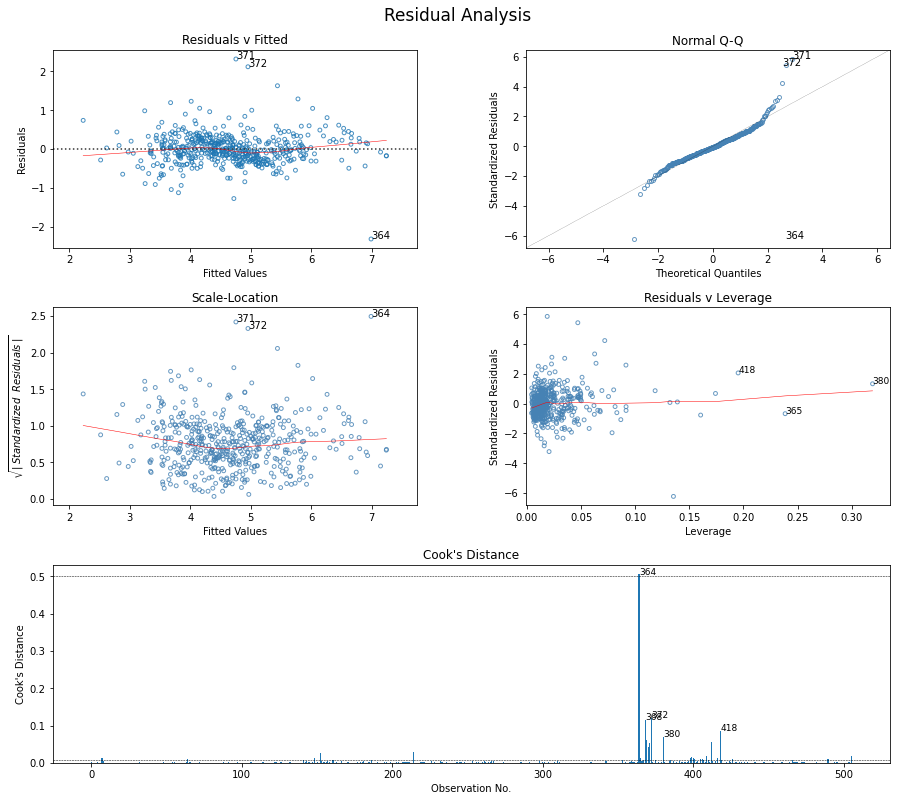

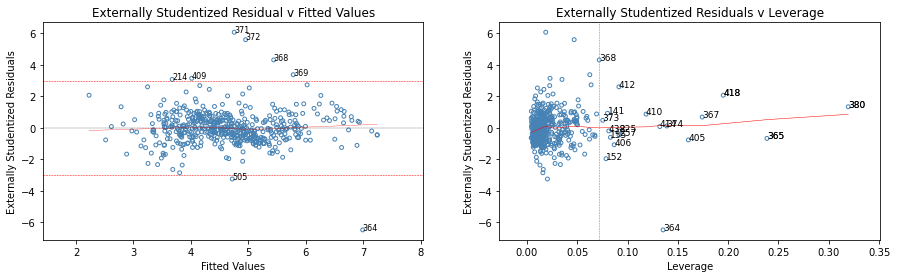

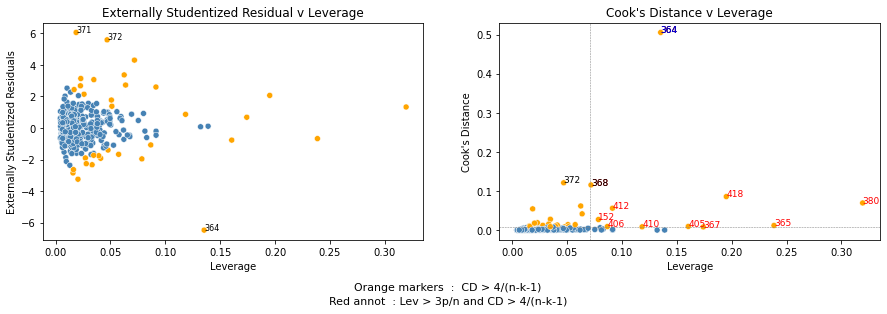

In [57]:
# Final model for p=10
formula_str = 'np.power(medv, 0.5) ~ crim + chas + nox + rm + dis + rad + ptratio + b + lstat \
 + np.square(lstat) + np.square(rm)'#' + np.power(crim, 2) + np.power(dis, 2)'
df_uc = df

msh1 = smf.ols(formula_str, data=df_uc).fit()
print(f'rsq = {round(msh1.rsquared*100, 4)}, \t\t incr: {round(82.219-round(msh1.rsquared*100, 3),4)*-1}')
print(f'adj_rsq = {round(msh1.rsquared_adj*100, 4)}, \t incr: {round(81.823-round(msh1.rsquared_adj*100, 3),4)*-1}')
print(f'mse = {round(msh1.scale, 4)}, \t\t decr: {round(0.159-round(msh1.scale, 3),4)}')

# Diagnostic plots
lm_diagnostic_plots(msh1, df_uc, 'medv')
esr_plots(msh1)
influence_diagnostic_plots(msh1)

 <div align="center"><b>-----------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

##### Model 2  : p = 11

rsq = 82.2996, 		 incr: 0.081
adj_rsq = 81.8687, 	 incr: 0.046
mse = 0.1589, 		 decr: 0.0


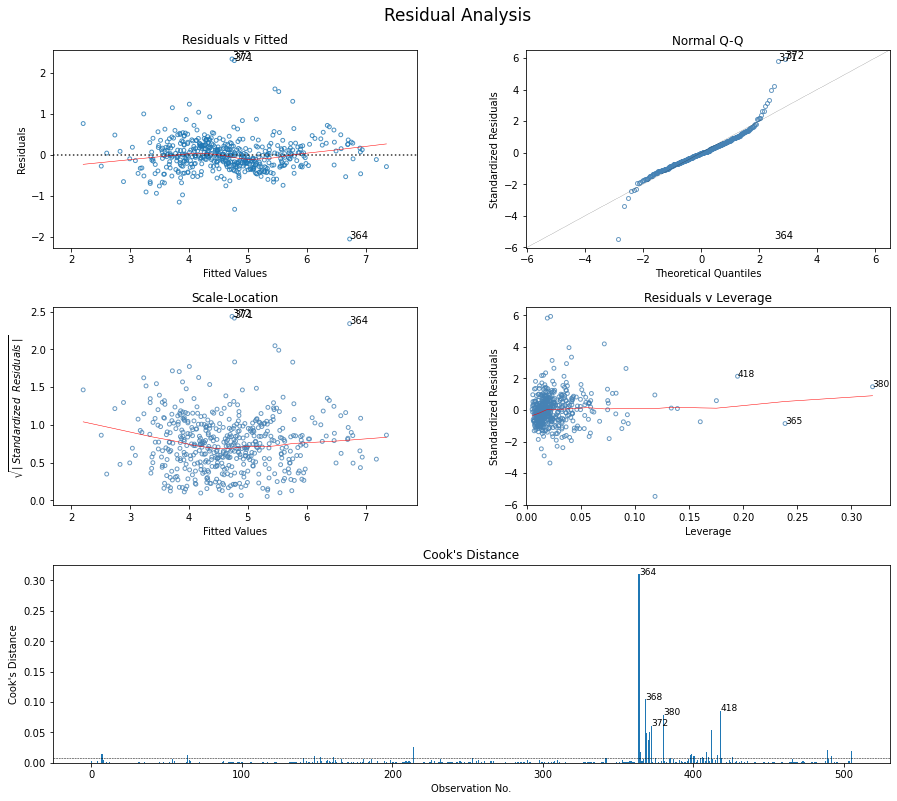

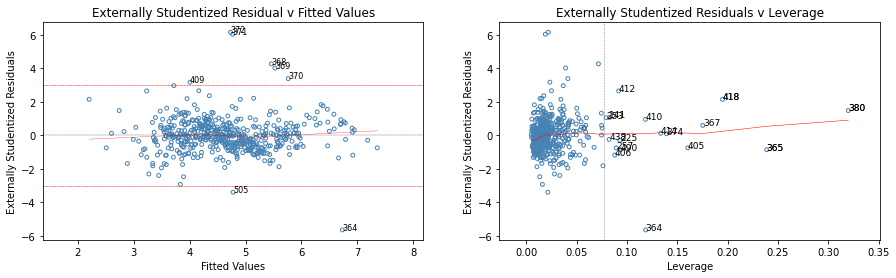

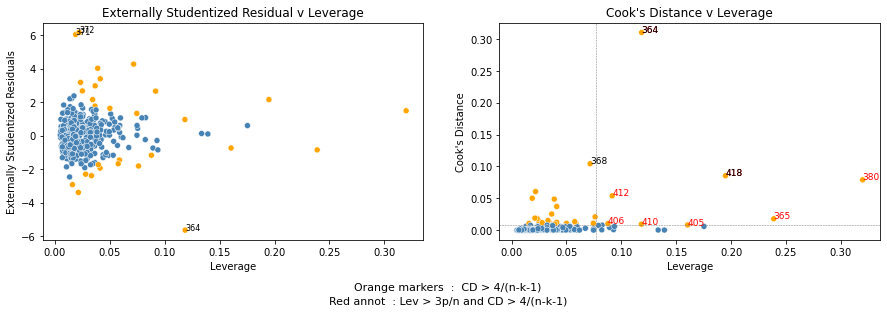

In [58]:
# Final model for p=11
formula_str = 'np.power(medv, 0.5) ~ crim + zn + nox + rm + dis + rad + tax + ptratio + b + lstat \
 + np.square(lstat) + np.square(rm)'#' + np.power(crim, 2) + np.power(dis, 2)'
df_uc = df

msh2 = smf.ols(formula_str, data=df_uc).fit()
print(f'rsq = {round(msh2.rsquared*100, 4)}, \t\t incr: {round(82.219-round(msh2.rsquared*100, 3),4)*-1}')
print(f'adj_rsq = {round(msh2.rsquared_adj*100, 4)}, \t incr: {round(81.823-round(msh2.rsquared_adj*100, 3),4)*-1}')
print(f'mse = {round(msh2.scale, 4)}, \t\t decr: {round(0.159-round(msh2.scale, 3),4)}')

# Diagnostic plots
lm_diagnostic_plots(msh2, df_uc, 'medv')
esr_plots(msh2)
influence_diagnostic_plots(msh2)

 <div align="center"><b>-----------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

##### Model 3  : p = 12

rsq = 82.6848, 		 incr: 0.466
adj_rsq = 82.2273, 	 incr: 0.404
mse = 0.1558, 		 decr: 0.003


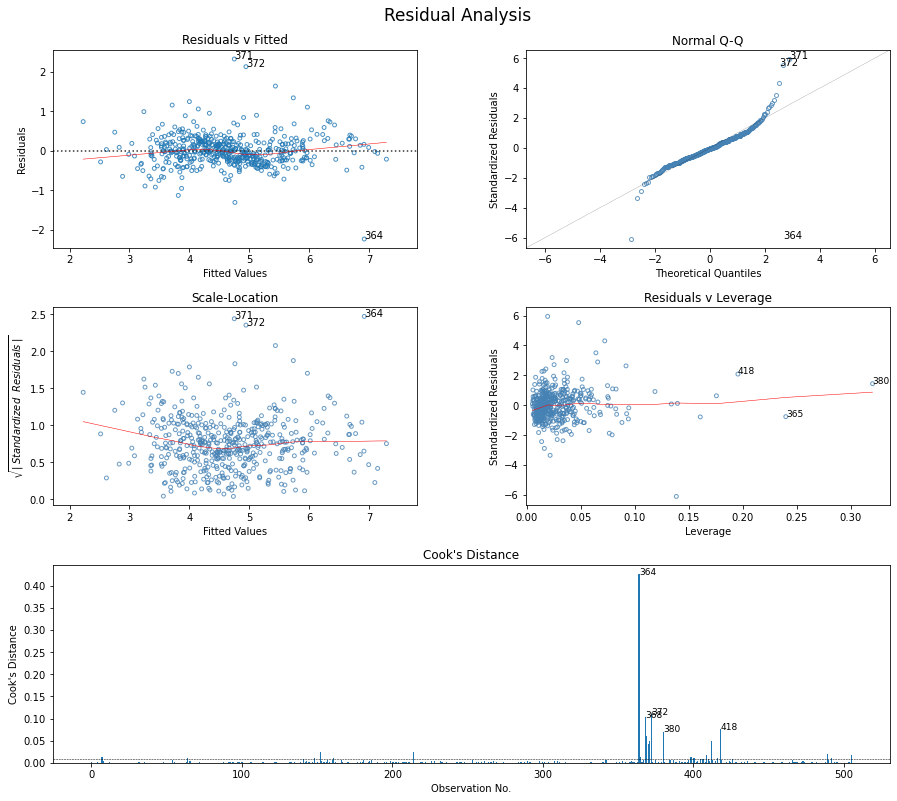

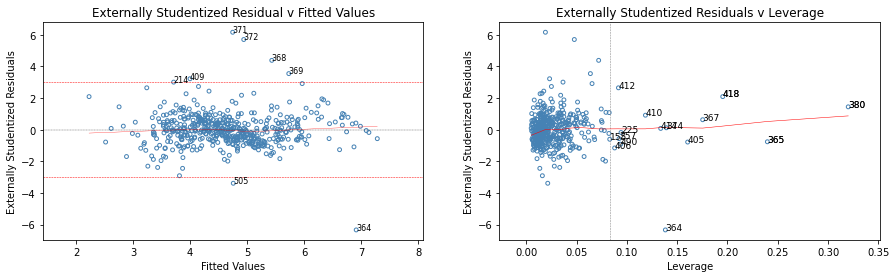

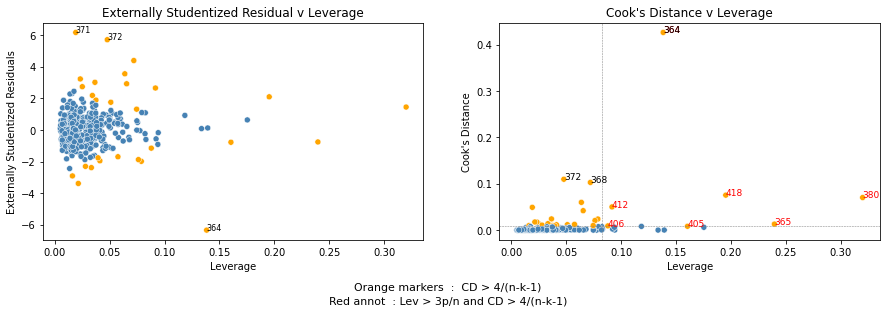

In [59]:
# Final model for p=12
formula_str = 'np.power(medv, 0.5) ~ crim + zn + chas + nox + rm + dis + rad + tax + ptratio + b + lstat\
  + np.square(lstat) + np.square(rm)'#' + np.power(nox, 2)'#' + np.power(dis, 2)'
df_uc = df

msh3 = smf.ols(formula_str, data=df_uc).fit()
print(f'rsq = {round(msh3.rsquared*100, 4)}, \t\t incr: {round(82.219-round(msh3.rsquared*100, 3),4)*-1}')
print(f'adj_rsq = {round(msh3.rsquared_adj*100, 4)}, \t incr: {round(81.823-round(msh3.rsquared_adj*100, 3),4)*-1}')
print(f'mse = {round(msh3.scale, 4)}, \t\t decr: {round(0.159-round(msh3.scale, 3),4)}')

# Diagnostic plots
lm_diagnostic_plots(msh3, df_uc, 'medv')
esr_plots(msh3)
influence_diagnostic_plots(msh3)

<div class="alert alert-block alert-info">
    There was not significant benefit (either in terms of increase in Adjusted r-squared or decrease in MSE) of including the additional terms from shortlisted models with p=11,12 into the model with p=10.<br>
    Therefore, final model shall be the one with p=10 and transformations for medv, lstat and rm.
</div>

##### Interactions

In [60]:
formula_str = regression_formula('np.power(medv, 0.5)', mallow_shortlist[10], interaction=True)
formula_str = formula_str + '+ np.power(lstat, 2) + np.power(rm, 2)'
formula_str

'np.power(medv, 0.5) ~ crim + chas + nox + rm + dis + rad + ptratio + b + lstat + crim:chas + crim:nox + crim:rm + crim:dis + crim:rad + crim:ptratio + crim:b + crim:lstat + chas:nox + chas:rm + chas:dis + chas:rad + chas:ptratio + chas:b + chas:lstat + nox:rm + nox:dis + nox:rad + nox:ptratio + nox:b + nox:lstat + rm:dis + rm:rad + rm:ptratio + rm:b + rm:lstat + dis:rad + dis:ptratio + dis:b + dis:lstat + rad:ptratio + rad:b + rad:lstat + ptratio:b + ptratio:lstat + b:lstat+ np.power(lstat, 2) + np.power(rm, 2)'

In [61]:
msh_i1 = smf.ols(formula_str, data=df).fit()
print(msh_i1.rsquared, msh_i1.rsquared_adj, msh_i1.scale)

# interaction terms with p-values very close to 0
msh_i1.pvalues[round(msh_i1.pvalues,4) == 0]

0.8904530502109465 0.8792113326561746 0.10587423197690855


crim:chas    3.639868e-05
rad:lstat    3.039761e-08
dtype: float64

 <div align="center"><b>-----------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

#### Final model candidate

In [62]:
formula_str = 'np.power(medv, 0.5) ~ crim + chas + nox + rm + dis + rad + ptratio + b + lstat\
+ crim:chas + rad:lstat + np.power(lstat, 2) + np.power(rm, 2)'

df_uc = df#.drop(index=364, axis=0)
msh_i2 = smf.ols(formula_str, data=df_uc).fit()
print(f'MSE : {msh_i2.scale}', end='')
msh_i2.summary()

MSE : 0.1427329073462936

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.power(medv, 0.5)   R-squared:                       0.841
Model:                             OLS   Adj. R-squared:                  0.837
Method:                  Least Squares   F-statistic:                     200.7
Date:                 Sat, 03 Apr 2021   Prob (F-statistic):          4.15e-187
Time:                         17:42:14   Log-Likelihood:                -218.35
No. Observations:                  506   AIC:                             464.7
Df Residuals:                      492   BIC:                             523.9
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.1191      0.890     14.744      0.000      11.371      14.867
crim                  -0.0158      0.003     -5.860      0.000      -0.021      -0.010
chas                   0.0313      0.084      0.372      0.710      -0.134       0.197
nox                   -2.2097      0.284     -7.790      0.000      -2.767      -1.652
rm                    -1.7506      0.267     -6.558      0.000      -2.275      -1.226
dis                   -0.1011      0.013     -7.769      0.000      -0.127      -0.076
rad                    0.0468      0.007      7.054      0.000       0.034       0.060
ptratio               -0.0869      0.010     -8.728      0.000      -0.106      -0.067
b                      0.0006      0.000      2.957      0.003       0.000       0.001
lstat                 -0.1187      0.011    -10.429      0.000      -0.141      -0.096
crim:chas              0.0855      0.028      3.034      0.003       0.030       0.141
rad:lstat             -0.0023      0.000     -6.369      0.000      -0.003      -0.002
np.power(lstat, 2)     0.0025      0.000      7.378      0.000       0.002       0.003
np.power(rm, 2)        0.1610      0.021      7.740      0.000       0.120       0.202
==============================================================================
Omnibus:                       89.650   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1282.986
Skew:                          -0.191   Prob(JB):                    2.53e-279
Kurtosis:                      10.792   Cond. No.                     2.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<div class="alert alert-block alert-info">
    Adding the interaction terms with p-values very close to 0 (i.e. equal to 0 on rounding up to 4 digits), to the model (p=10 model) has improved the model considerably.<br>
    - R-squared went up to 84.1 from 82.21.<br>
    - Adj r-squared increased to 83.7 from 81.8 earlier.<br>
    - MSE decreased to 0.1427 from 0.1593.
</div>

 <div align="center"><b>-----------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

#### Residual Analysis

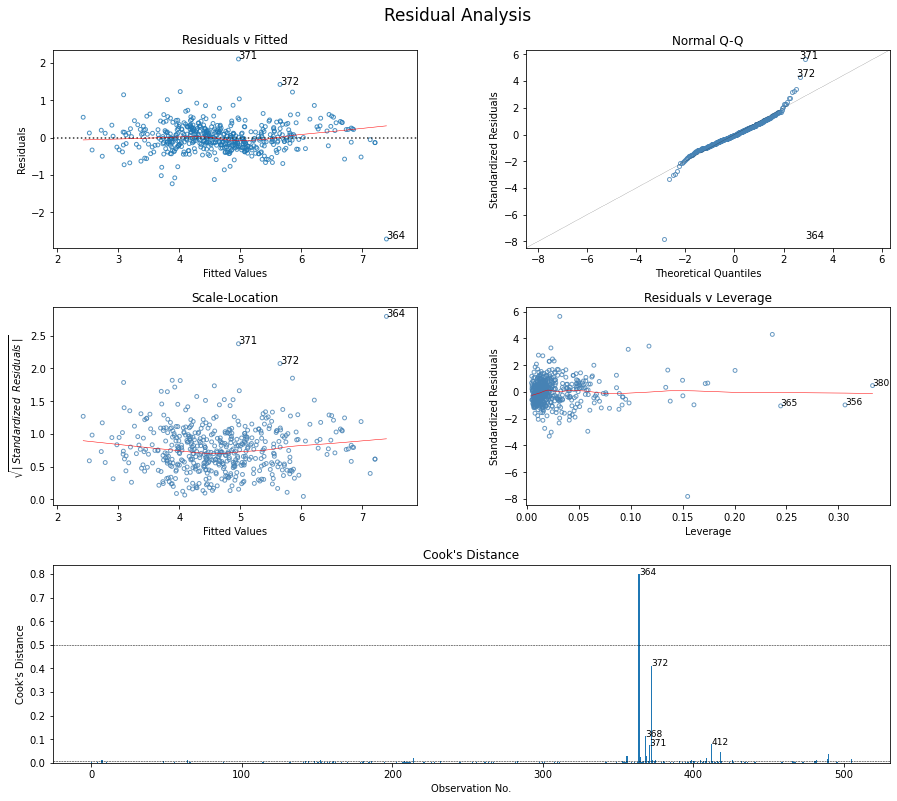

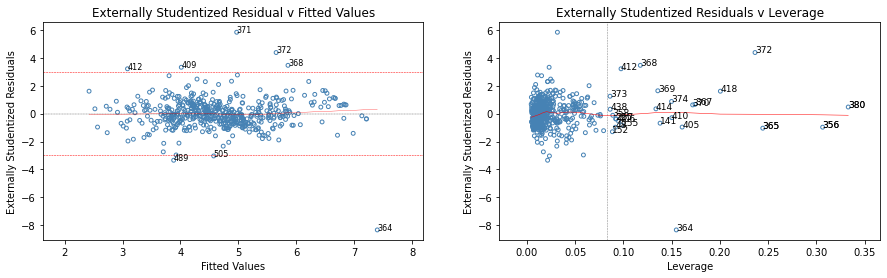

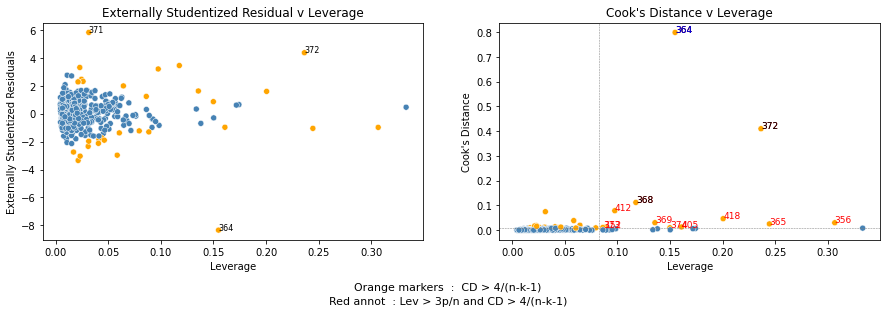

In [63]:
lm_diagnostic_plots(msh_i2, df_uc, 'medv')
esr_plots(msh_i2)
influence_diagnostic_plots(msh_i2)

<a id='obs-msh_i2'></a>

<div class="alert alert-block alert-info">
    <h5>Observations</h5><br>
    <b>Outliers</b><br>
    - An observation with externally studentized residual > 3 can be deemed an outlier (or extreme outlier).<br>
    There are 8 observations that cross this threshold. Observations 364 and 371 have |esr| > 5.<br>
    <br>
    <b>High leverage</b><br>
    - Leverage, denoted by $h_{ii}$, is a relative measure of unusualness of x values. $h_{ii}$ values change on change in the x values of a dataset.<br>
    - An observation with $h_{ii}$ > 3p/n can be considered a high leverage observation.<br>
    - There are many observations that cross this threshold.<br>
    <br>
    <b>Influential data point</b><br>
    A data point is influential if it unduly influences any part of regression analysis such as:<br>
    a) the predicted responses<br>
    b) the estimated slope coefficients<br>
    c) the hypothesis results<br>
    <br>
    <b>Highly influential observations</b><br>
    - An observation with Cook's Distance > 1, is considered highly influential, and one with CD > 0.5 potentially highly influential. But there is a more conservative threshold for smaller datasets, $\frac{4}{N - k - 1}$ which is used to highlight potentially influential observations.<br>
    - We can see in the Cook's Distance v Leverage plot, that there are plenty of observations that cross this threshold.
    Observations 364 and 372 stound out even amongst these.<br>
    Considering the fact that observations 364, 372, and 371 also have very extreme <i>Externally Studentised Residuals</i> (&gt; $\pm$ 4), we can consider removing them from the training dataset and see if that results in a lower MSE.
</div>

##### Outliers

In [64]:
# Externally Studentized Residuals
ext_resid = pd.Series(msh_i2.get_influence().resid_studentized_external, index=msh_i2.resid.index, 
                      name='ext_st_resid')

# Outliers
outliers = pd.concat([df.iloc[ext_resid[np.abs(ext_resid) > 3].index], 
                      ext_resid[np.abs(ext_resid) > 3]], axis=1)
outliers = outliers.iloc[outliers.ext_st_resid.abs().argsort()[::-1]]
outliers

crim   zn  indus  chas    nox     rm    age     dis   rad    tax  \
364   3.47428  0.0  18.10   1.0  0.718  8.780   82.9  1.9047  24.0  666.0   
371   9.23230  0.0  18.10   0.0  0.631  6.216  100.0  1.1691  24.0  666.0   
372   8.26725  0.0  18.10   1.0  0.668  5.875   89.6  1.1296  24.0  666.0   
368   4.89822  0.0  18.10   0.0  0.631  4.970  100.0  1.3325  24.0  666.0   
489   0.18337  0.0  27.74   0.0  0.609  5.414   98.3  1.7554   4.0  711.0   
409  14.43830  0.0  18.10   0.0  0.597  6.852  100.0  1.4655  24.0  666.0   
412  18.81100  0.0  18.10   0.0  0.597  4.628  100.0  1.5539  24.0  666.0   
505   0.04741  0.0  11.93   0.0  0.573  6.030   80.8  2.5050   1.0  273.0   

     ptratio       b  lstat  medv  ext_st_resid  
364     20.2  354.55   5.29  21.9     -8.342440  
371     20.2  366.15   9.53  50.0      5.840341  
372     20.2  347.88   8.88  50.0      4.384826  
368     20.2  375.52   3.26  50.0      3.466813  
489     20.1  344.05  23.97   7.0     -3.343380  
409     20.2  179.36  19.78  27.5      3.327551  
412     20.2   28.79  34.37  17.9      3.219186  
505     21.0  396.90   7.88  11.9     -3.033966

In [65]:
# Percentiles of outliers
from scipy.stats import percentileofscore as ptile

outlier_perc = pd.DataFrame()
for c in outliers.columns[:-1]:
    for i in outliers.index:
        outlier_perc.loc[i,c] = round(ptile(df[c], outliers.loc[i,c], kind='weak')/100, 2)

outlier_perc

crim    zn  indus  chas   nox    rm   age   dis   rad   tax  ptratio  \
364  0.74  0.74   0.89  1.00  0.93  1.00  0.56  0.19  1.00  0.99     0.89   
371  0.87  0.74   0.89  0.93  0.76  0.51  1.00  0.01  1.00  0.99     0.89   
372  0.86  0.74   0.89  1.00  0.80  0.24  0.66  0.00  1.00  0.99     0.89   
368  0.79  0.74   0.89  0.93  0.76  0.03  1.00  0.02  1.00  0.99     0.89   
489  0.44  0.74   1.00  0.93  0.71  0.07  0.89  0.13  0.38  1.00     0.61   
409  0.94  0.74   0.89  0.93  0.67  0.83  1.00  0.05  1.00  0.99     0.89   
412  0.96  0.74   0.89  0.93  0.67  0.01  1.00  0.08  1.00  0.99     0.89   
505  0.14  0.74   0.59  0.93  0.60  0.37  0.53  0.37  0.04  0.21     0.96   

        b  lstat  medv  
364  0.18   0.14  0.55  
371  0.21   0.40  1.00  
372  0.16   0.36  1.00  
368  0.25   0.03  1.00  
489  0.15   0.92  0.01  
409  0.08   0.85  0.79  
412  0.03   0.99  0.29  
505  1.00   0.31  0.08

In [66]:
# Full dataset
df.describe(percentiles=[.05,.1,.25,.5,.75,.9,.95])[1:].round(2)

crim      zn  indus  chas   nox    rm     age    dis    rad     tax  \
mean   3.61   11.36  11.14  0.07  0.55  6.28   68.57   3.80   9.55  408.24   
std    8.60   23.32   6.86  0.25  0.12  0.70   28.15   2.11   8.71  168.54   
min    0.01    0.00   0.46  0.00  0.38  3.56    2.90   1.13   1.00  187.00   
5%     0.03    0.00   2.18  0.00  0.41  5.31   17.72   1.46   2.00  222.00   
10%    0.04    0.00   2.91  0.00  0.43  5.59   26.95   1.63   3.00  233.00   
25%    0.08    0.00   5.19  0.00  0.45  5.89   45.02   2.10   4.00  279.00   
50%    0.26    0.00   9.69  0.00  0.54  6.21   77.50   3.21   5.00  330.00   
75%    3.68   12.50  18.10  0.00  0.62  6.62   94.07   5.19  24.00  666.00   
90%   10.75   42.50  19.58  0.00  0.71  7.15   98.80   6.82  24.00  666.00   
95%   15.79   80.00  21.89  1.00  0.74  7.59  100.00   7.83  24.00  666.00   
max   88.98  100.00  27.74  1.00  0.87  8.78  100.00  12.13  24.00  711.00   

      ptratio       b  lstat   medv  
mean    18.46  356.67  12.65  22.53  
std      2.16   91.29   7.14   9.20  
min     12.60    0.32   1.73   5.00  
5%      14.70   84.59   3.71  10.20  
10%     14.75  290.27   4.68  12.75  
25%     17.40  375.38   6.95  17.02  
50%     19.05  391.44  11.36  21.20  
75%     20.20  396.22  16.96  25.00  
90%     20.90  396.90  23.04  34.80  
95%     21.00  396.90  26.81  43.40  
max     22.00  396.90  37.97  50.00

<div class="alert alert-block alert-info">
    There are a few common themes among the observations found to be outliers.<br>
    - 6 out of 8 have high crim<br>
    - None of the towns has houses with large land tracts (&gt; 25k sq. ft)<br>
    - Mostly high indus (proportion of non-retail business acres)<br>
    - moderate to high nox<br>
    - moderate to high age<br>
    - low dis (proximity to business centers)<br>
    - mostly high tax<br>
    - moderate to high ptratio<br>
    - low b (in 7 out of 8 cases)
</div>

##### Residuals Normality test

ShapiroResult(statistic=0.9308727979660034, pvalue=1.5565340018958672e-14)

AndersonResult(statistic=3.9198831601386814, critical_values=array([0.572, 0.651, 0.781, 0.911, 1.084]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

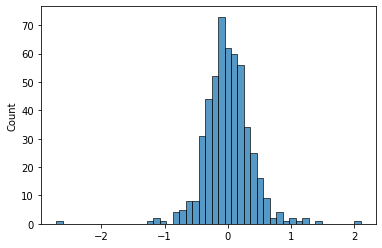

In [67]:
# Shapiro-Wilk test
from scipy.stats import shapiro
display(shapiro(msh_i2.resid))

# Anderson-Darling test
from scipy.stats import anderson
display(anderson(msh_i2.resid, dist='norm'))

# Histogram
sns.histplot(msh_i2.resid);

<div class="alert alert-block alert-info">
    Both Shapiro-Wilk and Anderson-Darling tests test the null hypothesis that the data was drawn from a normal distribution.<br>
    Presuming $\alpha$ = 0.05, p-values for both tests indicate that the null hypothesis has to be rejected.<br>
    There is statistical evidence to conclude that the residuals are not normally distributed.
</div>

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

#### Final model

In [68]:
# Data after removing highly influential points
df_uc = df.drop(index=[364, 371, 372], axis=0)

# Model
formula_str = 'np.power(medv, 0.5) ~ crim + chas + nox + rm + dis + rad + ptratio + b + lstat\
+ crim:chas + rad:lstat + np.power(lstat, 2) + np.power(rm, 2)'

final_model = smf.ols(formula_str, data=df_uc).fit()
print(f'MSE : {final_model.scale}', end='')
final_model.summary()

MSE : 0.11250804287177271

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.power(medv, 0.5)   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.869
Method:                  Least Squares   F-statistic:                     257.0
Date:                 Sat, 03 Apr 2021   Prob (F-statistic):          6.69e-209
Time:                         17:42:20   Log-Likelihood:                -157.17
No. Observations:                  503   AIC:                             342.3
Df Residuals:                      489   BIC:                             401.4
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             14.2093      0.801     17.738      0.000      12.635      15.783
crim                  -0.0162      0.002     -6.770      0.000      -0.021      -0.011
chas                   0.1138      0.076      1.505      0.133      -0.035       0.262
nox                   -1.9596      0.254     -7.726      0.000      -2.458      -1.461
rm                    -2.2976      0.244     -9.426      0.000      -2.777      -1.819
dis                   -0.0851      0.012     -7.305      0.000      -0.108      -0.062
rad                    0.0466      0.006      7.789      0.000       0.035       0.058
ptratio               -0.0767      0.009     -8.611      0.000      -0.094      -0.059
b                      0.0006      0.000      3.225      0.001       0.000       0.001
lstat                 -0.1089      0.010    -10.721      0.000      -0.129      -0.089
crim:chas              0.0585      0.028      2.087      0.037       0.003       0.114
rad:lstat             -0.0024      0.000     -7.363      0.000      -0.003      -0.002
np.power(lstat, 2)     0.0023      0.000      7.655      0.000       0.002       0.003
np.power(rm, 2)        0.2084      0.019     10.911      0.000       0.171       0.246
==============================================================================
Omnibus:                       24.706   Durbin-Watson:                   1.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.157
Skew:                           0.187   Prob(JB):                     5.25e-14
Kurtosis:                       4.667   Cond. No.                     2.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<div class="alert alert-block alert-info">
    Removing the highly influential observations (364, 372, 371) from the training dataset has improved the model considerably.<br>
    - R-squared went up to 87.2 from 84.1.<br>
    - Adj r-squared increased to 86.9 from 83.7 earlier.<br>
    - MSE decreased to 0.1125 from 0.1427.
</div>

 <div align="center"><b>-----------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

#### Residual Analysis

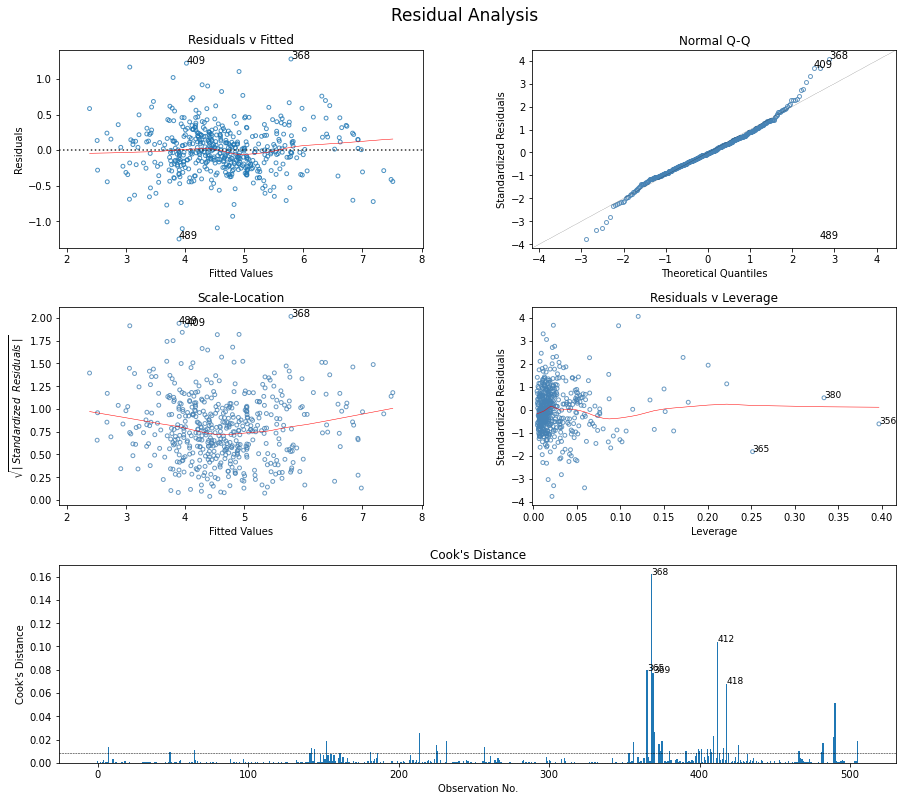

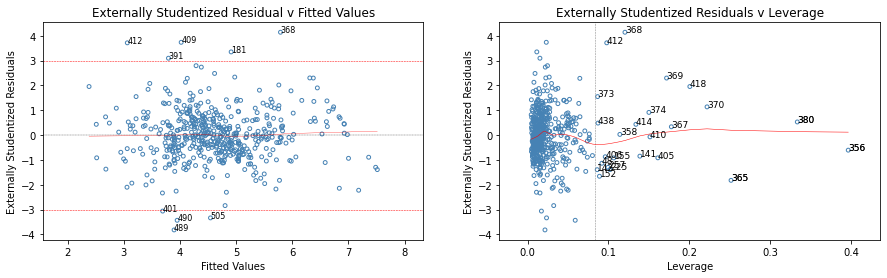

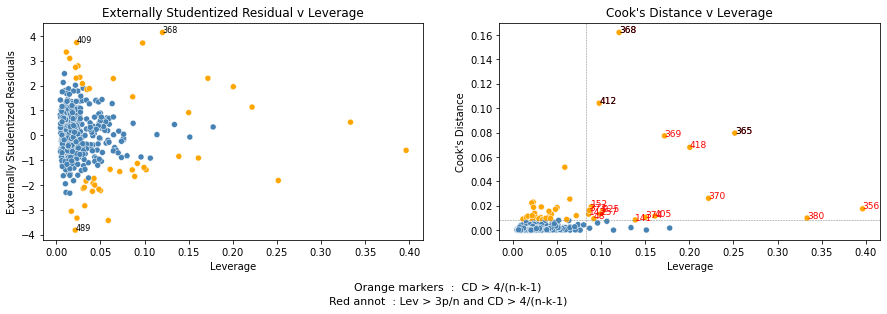

In [69]:
lm_diagnostic_plots(final_model, df_uc, 'medv')
esr_plots(final_model)
influence_diagnostic_plots(final_model)

ShapiroResult(statistic=0.9806085228919983, pvalue=3.0595529096899554e-06)

AndersonResult(statistic=1.8072539822575209, critical_values=array([0.572, 0.651, 0.781, 0.911, 1.083]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


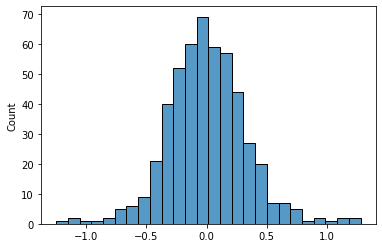

In [70]:
print(shapiro(final_model.resid))
print()
print(anderson(final_model.resid))
sns.histplot(final_model.resid);

<div class="alert alert-block alert-info">
    <b>Model assumptions</b><br>
    <br>
    <b>Linearity</b><br>
    There aren't any visible patterns in the Residuals vs Fitted plot. Linearity assumption holds true.<br>
    <br>
    <b>Normality</b><br>
    Although the residuals fail the normality tests of Shapiro-Wilk and Anderson-Darling, looking at the histogram, residuals look approximately normally distributed.<br>
    Regression analysis is fairly robust against departures from the normality assumption. 
    As long as the distribution of the errors at each level of X is not extremely different from a normal distribution, inferences about beta coefficients are not seriously affected.<br>
    <br>
    <b>Heteroscedasticity</b><br>
    In the Scale-Location plot, the scatter is pretty evenly spread. The assumption of equal variance in residuals seems to be valid.<br>
    <br>
    We can the accept this as the final model.
</div>

[go to toc](#index)

In [71]:
y_fm = np.power(y, 0.5)
X_fm = X.copy()
X_fm = X_fm.drop(['age', 'indus', 'tax', 'zn'], axis=1)
X_fm['crim_chas'] = X['crim']*X['chas']
X_fm['rad_lstat'] = X['rad']*X['lstat']
X_fm['lstat_2'] = X['lstat']**2
X_fm['rm_2'] = X['rm']**2
X_fm.columns

Index(['crim', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'b', 'lstat',
       'crim_chas', 'rad_lstat', 'lstat_2', 'rm_2'],
      dtype='object')

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [73]:
final_model2 = LinearRegression()
final_model2.fit(X_fm, y_fm)
scores = cross_val_score(final_model2, X_fm, y_fm, cv=5, scoring="r2")
scores

array([0.7750797 , 0.85393826, 0.62652313, 0.53348172, 0.55154966])

In [74]:
pd.Series(final_model2.coef_, index=X_fm.columns).round(4)

crim        -0.0158
chas         0.0313
nox         -2.2097
rm          -1.7506
dis         -0.1011
rad          0.0468
ptratio     -0.0869
b            0.0006
lstat       -0.1187
crim_chas    0.0855
rad_lstat   -0.0023
lstat_2      0.0025
rm_2         0.1610
dtype: float64

 <div align="center"><b>-----------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

#### Limitation of Best Subsets approach
The number of models the best subset algorithm has to consider grows exponentially with the number of predictors under consideration.  
A model with 10 variables has $2^{10}$ - 1 = 1023 subsets.<br>
A model with 20 variables has $2^{20}$ - 1 = 1,048,575 subsets.<br>

So, this approach works under certain computational constriants. In such cases we need to consider other methods for picking the most relevant predictors.

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

<font size=4><b>Wrapper Methods</b></font><br>
In wrapper methods, a metric (and cutoff) for model evaluation is decided and then a chosen machine learning alogorithm is used to build models on various combinations of features (adjusted by adding and/or removing features to/from the subset) till the best performant model is found.
For regression, evaluation metric can be p-value, r-squared, adjusted r-squared etc.<br>

Wrapper methods are computationally expensive and considered "greedy algorithms".

### 2) Backward Elimination
The process starts with a model that contains all of the candidate predictors. We then remove the predictor with the highest p-value exceeding the chosen level of significance and retrain the model. The process continues till none of the predictors fits the bill for removal.

<b>Limitation :</b><br>
This process is not gauranteed to yield the best subset.

In [75]:
predictors = [var for var in df.columns if var not in ['medv']]
y = df['medv']
excluded = []

while(len(predictors) > 0):
    X_new = sm.add_constant(df[predictors])
    model = sm.OLS(y, X_new).fit()
    pvals = pd.Series(model.pvalues.values[1:], index=predictors)
    if max(pvals) > 0.05:
        exclude = pvals.idxmax()
        predictors.remove(exclude)
        excluded.append(exclude)
    else:
        break

print(f'final list : {predictors}')
print(f'excluded : {excluded}')

final list : ['crim', 'zn', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
excluded : ['age', 'indus']


In [76]:
formula_str = regression_formula('medv', predictors)
smf.ols(formula_str, data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          5.54e-137
Time:                        17:42:26   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3411      5.067      7.171      0.000      26.385      46.298
crim          -0.1084      0.033     -3.307      0.001      -0.173      -0.044
zn             0.0458      0.014      3.390      0.001       0.019       0.072
chas           2.7187      0.854      3.183      0.002       1.040       4.397
nox          -17.3760      3.535     -4.915      0.000     -24.322     -10.430
rm             3.8016      0.406      9.356      0.000       3.003       4.600
dis           -1.4927      0.186     -8.037      0.000      -1.858      -1.128
rad            0.2996      0.063      4.726      0.000       0.175       0.424
tax           -0.0118      0.003     -3.493      0.001      -0.018      -0.005
ptratio       -0.9465      0.129     -7.334      0.000      -1.200      -0.693
b              0.0093      0.003      3.475      0.001       0.004       0.015
lstat         -0.5226      0.047    -11.019      0.000      -0.616      -0.429
==============================================================================
Omnibus:                      178.430   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              787.785
Skew:                           1.523   Prob(JB):                    8.60e-172
Kurtosis:                       8.300   Cond. No.                     1.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[go to toc](#index)

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

### 3) RFE (Recursive Feature Elimination)
The RFE technique starts off with the full set of features and eliminates the least important features  through a recursive procedure of model building and feature elimination, until a predetermined number of features remain.

There are two important configuration options when using RFE:<br>
a) the choice in the number of features to select, and <br>
b) the choice of the algorithm used to help choose features.

<br>

Resources : <br>
    - [Using RFE](https://machinelearningmastery.com/rfe-feature-selection-in-python/)<br>
    - [Sklearn - Model Evaluation - scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)<br>
    - [Cross-validation](https://www.youtube.com/watch?v=wjILv3-UGM8)

In [77]:
from sklearn.linear_model import LinearRegression    # algorithm for wrapper method
from sklearn.feature_selection import RFE            # wrapper method
from sklearn.model_selection import train_test_split

#### Optimum number of features

In [78]:
num_feat = list(range(1, len(X.columns)))
highest_score = 0
optimum_num_feat = 0
score_list = []
for n in range(len(num_feat)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=num_feat[n])
    training_rfe = rfe.fit_transform(X_train, y_train)
    test_rfe = rfe.transform(X_test)
    model.fit(training_rfe, y_train)
    score = model.score(test_rfe, y_test)
    score_list.append(score)
    if score > highest_score:
        highest_score = score
        optimum_num_feat = num_feat[n]

print(f'Optimum number of features: {optimum_num_feat}')
print(f'Score with {optimum_num_feat} features: {highest_score}')

Optimum number of features: 10
Score with 10 features: 0.6635808601043206


#### Model

In [79]:
xvars = [x for x in df.columns if x not in ['medv']]
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=10)
rfe_model = rfe.fit_transform(X, y)
model.fit(rfe_model, y)
selected_features = pd.Series(xvars)[rfe.support_].values
selected_features

array(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad',
       'ptratio', 'lstat'], dtype=object)

In [80]:
a = smf.ols('medv ~ crim + zn + indus + chas + nox + rm + dis + rad + ptratio + lstat', data=df).fit()
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     132.7
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          4.02e-133
Time:                        17:42:26   Log-Likelihood:                -1510.6
No. Observations:                 506   AIC:                             3043.
Df Residuals:                     495   BIC:                             3090.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.8099      4.942      8.055      0.000      30.099      49.521
crim          -0.1204      0.033     -3.617      0.000      -0.186      -0.055
zn             0.0364      0.014      2.681      0.008       0.010       0.063
indus         -0.0775      0.056     -1.375      0.170      -0.188       0.033
chas           3.2042      0.870      3.682      0.000       1.494       4.914
nox          -19.5660      3.737     -5.236      0.000     -26.909     -12.223
rm             3.7738      0.414      9.105      0.000       2.959       4.588
dis           -1.5147      0.195     -7.787      0.000      -1.897      -1.133
rad            0.1119      0.041      2.727      0.007       0.031       0.192
ptratio       -0.9685      0.133     -7.304      0.000      -1.229      -0.708
lstat         -0.5471      0.048    -11.362      0.000      -0.642      -0.452
==============================================================================
Omnibus:                      162.407   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              640.919
Skew:                           1.413   Prob(JB):                    6.70e-140
Kurtosis:                       7.735   Cond. No.                         820.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div align="center"><b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b></div>

### References


[go to toc](#index)

<div align="center"><b>-------------------------------------------- &ensp; <i>That's All Folks!</i> &ensp; --------------------------------------------</b></div>